# Nuclear Mass Neural Net

This short tensorflow toy trains a standard neural network to output binding energy based on an input neutron and proton number. The first code block uses a saved model and should stand by itself, but the training stuff is down below.

Also included are a couple of widgets. Be sure to run the first cell first to define some functions, then the widgets should run fine provided you have the environment set up correctly.

In [27]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import h5py
import pandas as pd
import sklearn.linear_model as skl
from pylab import plt, mpl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)

# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# input N,Z return model estimated binding energy
def BE(N, Z):
    # Hard code the data averages
    zm=55.16940328394073
    nm=76.95234281137365
    Zs=(Z - zm) / zm
    Ns=(N - nm) / nm

    nucleus=np.array([[Zs,Ns]])

    [[BE]] = model.predict(nucleus,verbose=0)
    return BE

def GenerateMasses():
    zm=55.16940328394073
    nm=76.95234281137365
    nuclei=[[0,0]]
    for zi in range(1,120):
        Zs=(zi - zm) / zm
        for ni in range(0,160):
            Ns=(ni - nm) / nm
            nuclei=np.append(nuclei,[[Zs,Ns]],axis=0)
            
    energies=model.predict(nuclei,verbose=0)
    nuclei[:,0]=nuclei[:,0]*zm+zm
    nuclei[:,1]=nuclei[:,1]*nm+nm
    a_sum=np.sum(nuclei,axis=1)
    return pd.DataFrame({'A':a_sum,'Z':nuclei[:,0],'N':nuclei[:,1],'Energies':energies[:,0]*a_sum[:]})

def CalcSepEn(Z,A1,A2):
    Nucleus=predicted.loc[lambda predicted: predicted.Z==Z, :]
    Nucleus=Nucleus.loc[(Nucleus['A'] >= A1) & (Nucleus['A'] <= A2)]
    Nucleus['NeutronSeparationEnergies'] = Nucleus['Energies'].diff(+1)
    return Nucleus

    
# Given a Z value and number of separation, add neutron separation energies for the nucleus
#def NSepEn(Z,nsep,df):
#    for N in range[0:2*Z]:
        
# load our pretrained model
massmodel = tf.keras.models.load_model('neuralmasses_testing.h5', custom_objects={'R2': R2})

# Generate a massive mass chart
predicted=GenerateMasses()

/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Features:
   Shape: (1997, 2)
   Type: float64

Training Targets:
   Shape: (1997,)
   Type: float64

Test Features:
   Shape: (500, 2)
   Type: float64

Test Targets:
   Shape: (500,)
   Type: float64



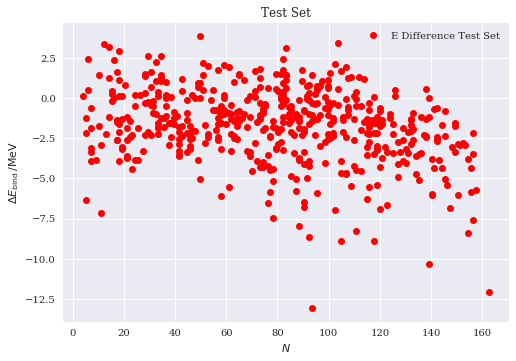

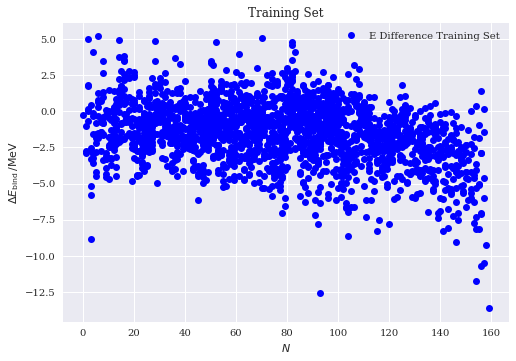

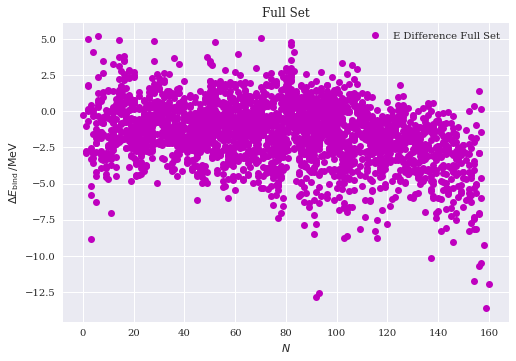

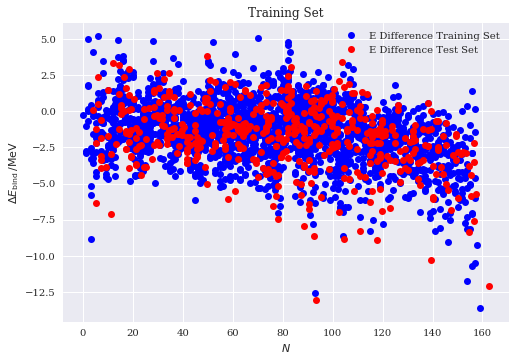

In [28]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(15,9))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)
    
# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("MassEval2016.dat"),'r')

# Prevent TensorFlow from showing us deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)

# Read the experimental data with Pandas
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000

# Group the DataFrame by nucleon number, A.
#Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
#Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])
A = Masses['A']
Z = Masses['Z']
N = Masses['N']
Element = Masses['Element']
Energies = Masses['Ebinding']

## All above comes from another notebook

# Build input array
xx = (Z.as_matrix()[:],N.as_matrix()[:])
xx = np.asarray(xx)
xx = xx.T
yy = Energies
#en_test=Energies.as_matrix()[:]
# Get a test set for later
x_train, x_test, y_train, y_test = train_test_split(xx,yy,test_size=0.2,random_state=42)

fullx = (Z.as_matrix()[:],N.as_matrix()[:])
fullx = np.asarray(fullx)
fullx = fullx.T

# Scale input

xs_train = x_train.astype(np.float64)
xs_test = x_test.astype(np.float64)
xs_full = fullx.astype(np.float64)

xs_train[:,0] = (x_train[:,0] - np.average(xx[:,0])) / np.average(xx[:,0])
xs_test[:,0] = (x_test[:,0] - np.average(xx[:,0])) / np.average(xx[:,0])
xs_full[:,0] = (fullx[:,0] - np.average(xx[:,0])) / np.average(xx[:,0])
xs_train[:,1] = (x_train[:,1] - np.average(xx[:,1])) / np.average(xx[:,1])
xs_test[:,1] = (x_test[:,1] - np.average(xx[:,1])) / np.average(xx[:,1])
xs_full[:,1] = (fullx[:,1] - np.average(xx[:,1])) / np.average(xx[:,1])

print('Training Features:\n   Shape: {}\n   Type: {}\n'.format(xs_train.shape, xs_train.dtype))
print('Training Targets:\n   Shape: {}\n   Type: {}\n'.format(y_train.shape, y_train.dtype))
print('Test Features:\n   Shape: {}\n   Type: {}\n'.format(xs_test.shape, xs_test.dtype))
print('Test Targets:\n   Shape: {}\n   Type: {}\n'.format(y_test.shape, y_test.dtype))

en_out=massmodel.predict(xs_test)
trainen_out=massmodel.predict(xs_train)
fullen_out=massmodel.predict(xs_full)



# Shift back for plotting
zm=55.16940328394073
nm=76.95234281137365
x_shift=xs_test
xt_shift=xs_train
xt_full=xs_full
x_shift[:,0]=xs_test[:,0]*np.average(x_test[:,0])+np.average(x_test[:,0])
x_shift[:,1]=xs_test[:,1]*np.average(x_test[:,1])+np.average(x_test[:,1])
xt_shift[:,0]=xs_train[:,0]*zm+zm
xt_shift[:,1]=xs_train[:,1]*nm+nm
xt_full[:,0]=xs_full[:,0]*zm+zm
xt_full[:,1]=xs_full[:,1]*nm+nm

a_sum=np.sum(x_shift,axis=1)

en_test=np.asmatrix(y_test)[0,:].T
diff = en_test-en_out
diff = diff.T
trainen_test=np.asmatrix(y_train)[0,:].T
traindiff = trainen_test-trainen_out

fullen_test=np.asmatrix(Energies)[0,:].T
fulldiff = fullen_test-fullen_out

testA = np.sum(x_shift,axis=1)
trainA = np.sum(xt_shift,axis=1)
fullA = np.sum(xt_full,axis=1)



fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')


plt.title(label="Test Set")
ax.plot(x_shift[:,1], testA*np.asarray(diff.T).squeeze(),'ro',label='E Difference Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')

ax.legend()
save_fig("Difference")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(xt_shift[:,1], trainA*np.asarray(traindiff.T).squeeze(),'ro',label='E Difference Training Set',c='b')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differencetrain")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(xt_full[:,1], fullA*np.asarray(fulldiff.T).squeeze(),'ro',label='E Difference Full Set',c='m')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Full Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differencefull")
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\Delta E_\mathrm{bind}\,/\mathrm{MeV}$')
#ax.plot(Masses['N'], Masses['Ebinding'], 'ro',
#            label='Ame2016', alpha=0.7,c='b')

ax.plot(xt_shift[:,1], trainA*np.asarray(traindiff.T).squeeze(),'ro',label='E Difference Training Set',c='b')
ax.plot(x_shift[:,1], testA*np.asarray(diff.T).squeeze(),'ro',label='E Difference Test Set',c='r')
#ax.plot(x_shift[:,1], y_test,'ro',c='r')
plt.title(label="Training Set")
#plt.ylim(-0.5,0.5)
ax.legend()
save_fig("Differenceboth")
plt.show()

## Separation energy widget

Input a proton number and bounds for total A and watch what the neural net predicts. Note, some experimental data may have been used in the training! 

In [68]:
from ipywidgets import interactive,interact_manual
def f(Z,A1,A2):
    Nucleus=CalcSepEn(int(Z),int(A1),int(A2))
    MakePlot([Nucleus.A], [Nucleus.NeutronSeparationEnergies], ['b'], ['Neutron Separation Energy'], ['$A$','$S_n$'])
    plt.show()

interactive_plot = interact_manual(f, Z="Input Proton Number", A1="Input Minimum A", A2="Input Maximum A")

interactive(children=(Text(value='Input Proton Number', description='Z'), Text(value='Input Minimum A', descri…

## Binding energy widget

Input Z and N to see what the neural net predicts for the binding energy.

In [71]:
from ipywidgets import interactive,interact_manual
def f(Z,N):
    A=int(Z)+int(N)
    pBE=BE(int(N),int(Z))
    print("Binding Energy per Nucleon:",pBE)
    print("Total Binding Energy:",pBE*A)

interactive = interact_manual(f, Z="Input Proton Number", N="Input Neutron Number")


interactive(children=(Text(value='Input Proton Number', description='Z'), Text(value='Input Neutron Number', d…

/home/kyle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Training Features:
   Shape: (1997, 2)
   Type: float64

Training Targets:
   Shape: (1997,)
   Type: float64

Test Features:
   Shape: (500, 2)
   Type: float64

Test Targets:
   Shape: (500,)
   Type: float64

Train on 1597 samples, validate on 400 samples
Epoch 1/10000
1597/1597 [==============================] - 2s 1ms/sample - loss: 64.9811 - R2: -533.7310 - val_loss: 64.7480 - val_R2: -509.2959
Epoch 2/10000
1597/1597 [==============================] - 1s 533us/sample - loss: 64.1953 - R2: -552.4045 - val_loss: 63.9421 - val_R2: -555.3758
Epoch 3/10000
1597/1597 [==============================] - 1s 518us/sample - loss: 63.2744 - R2: -526.0501 - val_loss: 62.9631 - val_R2: -497.4530
Epoch 4/10000
1597/1597 [==============================] - 1s 473us/sample - loss: 62.1604 - R2: -520.9976 - val_loss: 61.7593 - val_R2: -503.1347
Epoch 5/10000
1597/1597 [==============================] - 1s 474us/sample - loss: 60.7333 - R2: -494.1467 - val_loss: 60.1349 - val_R2: -493.2903
Epoch 6/

Epoch 56/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 1.1527 - R2: -3.5587 - val_loss: 1.0826 - val_R2: -3.4483
Epoch 57/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 1.0938 - R2: -3.3430 - val_loss: 1.0284 - val_R2: -2.7805
Epoch 58/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 1.0391 - R2: -3.2658 - val_loss: 0.9754 - val_R2: -2.6806
Epoch 59/10000
1597/1597 [==============================] - 1s 500us/sample - loss: 0.9877 - R2: -2.5256 - val_loss: 0.9285 - val_R2: -3.0936
Epoch 60/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.9404 - R2: -2.4269 - val_loss: 0.8849 - val_R2: -1.9236
Epoch 61/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.8966 - R2: -2.0850 - val_loss: 0.8437 - val_R2: -1.9146
Epoch 62/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.8555 - R2: -1.9236 - val_loss: 0.8058 - val_R2: -1.5901
Epoch 

Epoch 114/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.3080 - R2: 0.2557 - val_loss: 0.3014 - val_R2: 0.3850
Epoch 115/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.3068 - R2: 0.3015 - val_loss: 0.2963 - val_R2: 0.2192
Epoch 116/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.3030 - R2: 0.3786 - val_loss: 0.2930 - val_R2: 0.4286
Epoch 117/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 0.3005 - R2: 0.1853 - val_loss: 0.2899 - val_R2: 0.4989
Epoch 118/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.2975 - R2: 0.3290 - val_loss: 0.2874 - val_R2: 0.3866
Epoch 119/10000
1597/1597 [==============================] - 1s 499us/sample - loss: 0.2941 - R2: 0.3304 - val_loss: 0.2848 - val_R2: 0.4337
Epoch 120/10000
1597/1597 [==============================] - 1s 472us/sample - loss: 0.2916 - R2: 0.3341 - val_loss: 0.2820 - val_R2: 0.4315
Epoch 121/100

1597/1597 [==============================] - 1s 466us/sample - loss: 0.1985 - R2: 0.5087 - val_loss: 0.1901 - val_R2: 0.5507
Epoch 173/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.1981 - R2: 0.5371 - val_loss: 0.1881 - val_R2: 0.5551
Epoch 174/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.1967 - R2: 0.5214 - val_loss: 0.1866 - val_R2: 0.6244
Epoch 175/10000
1597/1597 [==============================] - 1s 467us/sample - loss: 0.1953 - R2: 0.5438 - val_loss: 0.1858 - val_R2: 0.6539
Epoch 176/10000
1597/1597 [==============================] - 1s 444us/sample - loss: 0.1942 - R2: 0.6029 - val_loss: 0.1845 - val_R2: 0.5599
Epoch 177/10000
1597/1597 [==============================] - 1s 449us/sample - loss: 0.1931 - R2: 0.5348 - val_loss: 0.1834 - val_R2: 0.5319
Epoch 178/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.1923 - R2: 0.5816 - val_loss: 0.1828 - val_R2: 0.5828
Epoch 179/10000
1597/1597 [==

1597/1597 [==============================] - 1s 521us/sample - loss: 0.1520 - R2: 0.5733 - val_loss: 0.1316 - val_R2: 0.7333
Epoch 231/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.1506 - R2: 0.6351 - val_loss: 0.1315 - val_R2: 0.6052
Epoch 232/10000
1597/1597 [==============================] - 1s 522us/sample - loss: 0.1505 - R2: 0.6311 - val_loss: 0.1317 - val_R2: 0.6598
Epoch 233/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.1502 - R2: 0.6503 - val_loss: 0.1295 - val_R2: 0.6796
Epoch 234/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.1490 - R2: 0.6146 - val_loss: 0.1284 - val_R2: 0.6446
Epoch 235/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.1496 - R2: 0.6152 - val_loss: 0.1289 - val_R2: 0.7546
Epoch 236/10000
1597/1597 [==============================] - 1s 564us/sample - loss: 0.1489 - R2: 0.5956 - val_loss: 0.1279 - val_R2: 0.7635
Epoch 237/10000
1597/1597 [==

1597/1597 [==============================] - 1s 491us/sample - loss: 0.1295 - R2: 0.6847 - val_loss: 0.1002 - val_R2: 0.7669
Epoch 289/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.1286 - R2: 0.6758 - val_loss: 0.0994 - val_R2: 0.6952
Epoch 290/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.1287 - R2: 0.6371 - val_loss: 0.1001 - val_R2: 0.8074
Epoch 291/10000
1597/1597 [==============================] - 1s 476us/sample - loss: 0.1280 - R2: 0.6245 - val_loss: 0.0998 - val_R2: 0.7601
Epoch 292/10000
1597/1597 [==============================] - 1s 474us/sample - loss: 0.1283 - R2: 0.6270 - val_loss: 0.0975 - val_R2: 0.7178
Epoch 293/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.1272 - R2: 0.6217 - val_loss: 0.0984 - val_R2: 0.7839
Epoch 294/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.1273 - R2: 0.6456 - val_loss: 0.0970 - val_R2: 0.7765
Epoch 295/10000
1597/1597 [==

1597/1597 [==============================] - 1s 477us/sample - loss: 0.1160 - R2: 0.7021 - val_loss: 0.0819 - val_R2: 0.8725
Epoch 347/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.1152 - R2: 0.6823 - val_loss: 0.0813 - val_R2: 0.8071
Epoch 348/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.1159 - R2: 0.6762 - val_loss: 0.0798 - val_R2: 0.8107
Epoch 349/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.1149 - R2: 0.7152 - val_loss: 0.0796 - val_R2: 0.8201
Epoch 350/10000
1597/1597 [==============================] - 1s 511us/sample - loss: 0.1152 - R2: 0.6706 - val_loss: 0.0807 - val_R2: 0.7972
Epoch 351/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.1146 - R2: 0.6543 - val_loss: 0.0793 - val_R2: 0.7976
Epoch 352/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.1145 - R2: 0.7010 - val_loss: 0.0791 - val_R2: 0.8338
Epoch 353/10000
1597/1597 [==

1597/1597 [==============================] - 1s 481us/sample - loss: 0.1071 - R2: 0.6240 - val_loss: 0.0688 - val_R2: 0.8645
Epoch 405/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.1078 - R2: 0.7083 - val_loss: 0.0683 - val_R2: 0.8517
Epoch 406/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.1078 - R2: 0.6803 - val_loss: 0.0678 - val_R2: 0.8471
Epoch 407/10000
1597/1597 [==============================] - 1s 499us/sample - loss: 0.1077 - R2: 0.6846 - val_loss: 0.0679 - val_R2: 0.8514
Epoch 408/10000
1597/1597 [==============================] - 1s 481us/sample - loss: 0.1072 - R2: 0.7043 - val_loss: 0.0685 - val_R2: 0.7972
Epoch 409/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.1081 - R2: 0.7227 - val_loss: 0.0671 - val_R2: 0.8427
Epoch 410/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.1069 - R2: 0.6721 - val_loss: 0.0669 - val_R2: 0.8667
Epoch 411/10000
1597/1597 [==

1597/1597 [==============================] - 1s 491us/sample - loss: 0.1024 - R2: 0.7194 - val_loss: 0.0590 - val_R2: 0.8100
Epoch 463/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.1014 - R2: 0.7132 - val_loss: 0.0608 - val_R2: 0.8789
Epoch 464/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.1015 - R2: 0.7488 - val_loss: 0.0587 - val_R2: 0.8742
Epoch 465/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.1022 - R2: 0.7574 - val_loss: 0.0583 - val_R2: 0.8383
Epoch 466/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.1015 - R2: 0.7321 - val_loss: 0.0586 - val_R2: 0.8725
Epoch 467/10000
1597/1597 [==============================] - 1s 485us/sample - loss: 0.1014 - R2: 0.7582 - val_loss: 0.0586 - val_R2: 0.8659
Epoch 468/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.1012 - R2: 0.7335 - val_loss: 0.0581 - val_R2: 0.8917
Epoch 469/10000
1597/1597 [==

1597/1597 [==============================] - 1s 528us/sample - loss: 0.0973 - R2: 0.7357 - val_loss: 0.0537 - val_R2: 0.8631
Epoch 521/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0968 - R2: 0.7003 - val_loss: 0.0547 - val_R2: 0.9014
Epoch 522/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0974 - R2: 0.7270 - val_loss: 0.0528 - val_R2: 0.8802
Epoch 523/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.0980 - R2: 0.7176 - val_loss: 0.0546 - val_R2: 0.8753
Epoch 524/10000
1597/1597 [==============================] - 1s 466us/sample - loss: 0.0975 - R2: 0.7288 - val_loss: 0.0533 - val_R2: 0.8484
Epoch 525/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0974 - R2: 0.7663 - val_loss: 0.0530 - val_R2: 0.8722
Epoch 526/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0971 - R2: 0.7490 - val_loss: 0.0526 - val_R2: 0.8715
Epoch 527/10000
1597/1597 [==

1597/1597 [==============================] - 1s 476us/sample - loss: 0.0920 - R2: 0.7230 - val_loss: 0.0503 - val_R2: 0.9024
Epoch 579/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0925 - R2: 0.7958 - val_loss: 0.0489 - val_R2: 0.8881
Epoch 580/10000
1597/1597 [==============================] - 1s 511us/sample - loss: 0.0923 - R2: 0.8137 - val_loss: 0.0483 - val_R2: 0.8789
Epoch 581/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0927 - R2: 0.7864 - val_loss: 0.0484 - val_R2: 0.8785
Epoch 582/10000
1597/1597 [==============================] - 1s 479us/sample - loss: 0.0918 - R2: 0.7812 - val_loss: 0.0486 - val_R2: 0.9045
Epoch 583/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0919 - R2: 0.7823 - val_loss: 0.0485 - val_R2: 0.9009
Epoch 584/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0912 - R2: 0.7796 - val_loss: 0.0483 - val_R2: 0.9071
Epoch 585/10000
1597/1597 [==

1597/1597 [==============================] - 1s 477us/sample - loss: 0.0864 - R2: 0.7739 - val_loss: 0.0444 - val_R2: 0.8989
Epoch 637/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0863 - R2: 0.7785 - val_loss: 0.0437 - val_R2: 0.8987
Epoch 638/10000
1597/1597 [==============================] - 1s 464us/sample - loss: 0.0864 - R2: 0.7621 - val_loss: 0.0440 - val_R2: 0.9138
Epoch 639/10000
1597/1597 [==============================] - 1s 479us/sample - loss: 0.0857 - R2: 0.7817 - val_loss: 0.0447 - val_R2: 0.8791
Epoch 640/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0861 - R2: 0.7682 - val_loss: 0.0446 - val_R2: 0.9219
Epoch 641/10000
1597/1597 [==============================] - 1s 479us/sample - loss: 0.0869 - R2: 0.7790 - val_loss: 0.0444 - val_R2: 0.8684
Epoch 642/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0857 - R2: 0.7769 - val_loss: 0.0443 - val_R2: 0.8904
Epoch 643/10000
1597/1597 [==

1597/1597 [==============================] - 1s 506us/sample - loss: 0.0826 - R2: 0.8093 - val_loss: 0.0421 - val_R2: 0.9058
Epoch 695/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.0830 - R2: 0.7808 - val_loss: 0.0422 - val_R2: 0.9158
Epoch 696/10000
1597/1597 [==============================] - 1s 518us/sample - loss: 0.0823 - R2: 0.7783 - val_loss: 0.0414 - val_R2: 0.9211
Epoch 697/10000
1597/1597 [==============================] - 1s 485us/sample - loss: 0.0826 - R2: 0.8056 - val_loss: 0.0420 - val_R2: 0.9018
Epoch 698/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0825 - R2: 0.7722 - val_loss: 0.0411 - val_R2: 0.9129
Epoch 699/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 0.0817 - R2: 0.7728 - val_loss: 0.0419 - val_R2: 0.8732
Epoch 700/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0824 - R2: 0.7761 - val_loss: 0.0415 - val_R2: 0.9205
Epoch 701/10000
1597/1597 [==

1597/1597 [==============================] - 1s 478us/sample - loss: 0.0794 - R2: 0.7776 - val_loss: 0.0407 - val_R2: 0.9254
Epoch 753/10000
1597/1597 [==============================] - 1s 469us/sample - loss: 0.0797 - R2: 0.8192 - val_loss: 0.0396 - val_R2: 0.9098
Epoch 754/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0792 - R2: 0.7996 - val_loss: 0.0393 - val_R2: 0.9219
Epoch 755/10000
1597/1597 [==============================] - 1s 499us/sample - loss: 0.0798 - R2: 0.7649 - val_loss: 0.0394 - val_R2: 0.9132
Epoch 756/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0794 - R2: 0.8021 - val_loss: 0.0401 - val_R2: 0.9098
Epoch 757/10000
1597/1597 [==============================] - 1s 485us/sample - loss: 0.0794 - R2: 0.8207 - val_loss: 0.0393 - val_R2: 0.9038
Epoch 758/10000
1597/1597 [==============================] - 1s 476us/sample - loss: 0.0791 - R2: 0.8008 - val_loss: 0.0421 - val_R2: 0.9075
Epoch 759/10000
1597/1597 [==

1597/1597 [==============================] - 1s 517us/sample - loss: 0.0770 - R2: 0.8194 - val_loss: 0.0372 - val_R2: 0.9180
Epoch 811/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0771 - R2: 0.7860 - val_loss: 0.0379 - val_R2: 0.9237
Epoch 812/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0764 - R2: 0.7974 - val_loss: 0.0398 - val_R2: 0.9249
Epoch 813/10000
1597/1597 [==============================] - 1s 473us/sample - loss: 0.0776 - R2: 0.8200 - val_loss: 0.0387 - val_R2: 0.9199
Epoch 814/10000
1597/1597 [==============================] - 1s 461us/sample - loss: 0.0771 - R2: 0.8049 - val_loss: 0.0385 - val_R2: 0.8636
Epoch 815/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0776 - R2: 0.7897 - val_loss: 0.0373 - val_R2: 0.8919
Epoch 816/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0771 - R2: 0.8093 - val_loss: 0.0371 - val_R2: 0.9144
Epoch 817/10000
1597/1597 [==

1597/1597 [==============================] - 1s 503us/sample - loss: 0.0753 - R2: 0.8451 - val_loss: 0.0359 - val_R2: 0.8913
Epoch 869/10000
1597/1597 [==============================] - 1s 451us/sample - loss: 0.0756 - R2: 0.8297 - val_loss: 0.0350 - val_R2: 0.9046
Epoch 870/10000
1597/1597 [==============================] - 1s 533us/sample - loss: 0.0748 - R2: 0.8236 - val_loss: 0.0350 - val_R2: 0.9034
Epoch 871/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0758 - R2: 0.8050 - val_loss: 0.0354 - val_R2: 0.9161
Epoch 872/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0755 - R2: 0.7958 - val_loss: 0.0350 - val_R2: 0.9254
Epoch 873/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0753 - R2: 0.8008 - val_loss: 0.0354 - val_R2: 0.9175
Epoch 874/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0741 - R2: 0.8071 - val_loss: 0.0374 - val_R2: 0.9245
Epoch 875/10000
1597/1597 [==

1597/1597 [==============================] - 1s 506us/sample - loss: 0.0741 - R2: 0.8197 - val_loss: 0.0334 - val_R2: 0.8882
Epoch 927/10000
1597/1597 [==============================] - 1s 511us/sample - loss: 0.0728 - R2: 0.8545 - val_loss: 0.0347 - val_R2: 0.9393
Epoch 928/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0728 - R2: 0.8296 - val_loss: 0.0335 - val_R2: 0.9238
Epoch 929/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.0723 - R2: 0.8256 - val_loss: 0.0345 - val_R2: 0.9317
Epoch 930/10000
1597/1597 [==============================] - 1s 475us/sample - loss: 0.0727 - R2: 0.8197 - val_loss: 0.0375 - val_R2: 0.9250
Epoch 931/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0740 - R2: 0.8011 - val_loss: 0.0349 - val_R2: 0.9284
Epoch 932/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0733 - R2: 0.8341 - val_loss: 0.0343 - val_R2: 0.9353
Epoch 933/10000
1597/1597 [==

1597/1597 [==============================] - 1s 565us/sample - loss: 0.0703 - R2: 0.8157 - val_loss: 0.0319 - val_R2: 0.9200
Epoch 985/10000
1597/1597 [==============================] - 1s 524us/sample - loss: 0.0698 - R2: 0.8406 - val_loss: 0.0321 - val_R2: 0.8991
Epoch 986/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0715 - R2: 0.8349 - val_loss: 0.0327 - val_R2: 0.8894
Epoch 987/10000
1597/1597 [==============================] - 1s 500us/sample - loss: 0.0708 - R2: 0.8289 - val_loss: 0.0318 - val_R2: 0.9214
Epoch 988/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0705 - R2: 0.8061 - val_loss: 0.0321 - val_R2: 0.9255
Epoch 989/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0700 - R2: 0.8432 - val_loss: 0.0321 - val_R2: 0.9155
Epoch 990/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0701 - R2: 0.8261 - val_loss: 0.0330 - val_R2: 0.9254
Epoch 991/10000
1597/1597 [==

Epoch 1042/10000
1597/1597 [==============================] - 1s 536us/sample - loss: 0.0687 - R2: 0.8396 - val_loss: 0.0310 - val_R2: 0.9158
Epoch 1043/10000
1597/1597 [==============================] - 1s 538us/sample - loss: 0.0688 - R2: 0.8060 - val_loss: 0.0301 - val_R2: 0.8974
Epoch 1044/10000
1597/1597 [==============================] - 1s 500us/sample - loss: 0.0682 - R2: 0.8191 - val_loss: 0.0323 - val_R2: 0.9412
Epoch 1045/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0698 - R2: 0.8391 - val_loss: 0.0318 - val_R2: 0.9132
Epoch 1046/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0683 - R2: 0.8552 - val_loss: 0.0314 - val_R2: 0.9359
Epoch 1047/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0692 - R2: 0.8438 - val_loss: 0.0301 - val_R2: 0.9445
Epoch 1048/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0692 - R2: 0.8585 - val_loss: 0.0324 - val_R2: 0.9147
Epoch 

Epoch 1100/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0673 - R2: 0.8298 - val_loss: 0.0300 - val_R2: 0.9236
Epoch 1101/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0680 - R2: 0.8615 - val_loss: 0.0291 - val_R2: 0.9079
Epoch 1102/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.0677 - R2: 0.8471 - val_loss: 0.0292 - val_R2: 0.9182
Epoch 1103/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0674 - R2: 0.8317 - val_loss: 0.0296 - val_R2: 0.9400
Epoch 1104/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0672 - R2: 0.8245 - val_loss: 0.0300 - val_R2: 0.9142
Epoch 1105/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0683 - R2: 0.8492 - val_loss: 0.0300 - val_R2: 0.9247
Epoch 1106/10000
1597/1597 [==============================] - 1s 485us/sample - loss: 0.0674 - R2: 0.8310 - val_loss: 0.0297 - val_R2: 0.9174
Epoch 

Epoch 1158/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0663 - R2: 0.8615 - val_loss: 0.0288 - val_R2: 0.9368
Epoch 1159/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0653 - R2: 0.8236 - val_loss: 0.0305 - val_R2: 0.9317
Epoch 1160/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0657 - R2: 0.8336 - val_loss: 0.0286 - val_R2: 0.9177
Epoch 1161/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0648 - R2: 0.8422 - val_loss: 0.0302 - val_R2: 0.9352
Epoch 1162/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0657 - R2: 0.8513 - val_loss: 0.0285 - val_R2: 0.9274
Epoch 1163/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0661 - R2: 0.8511 - val_loss: 0.0304 - val_R2: 0.9388
Epoch 1164/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0652 - R2: 0.8451 - val_loss: 0.0281 - val_R2: 0.9278
Epoch 

1597/1597 [==============================] - 1s 501us/sample - loss: 0.0641 - R2: 0.8598 - val_loss: 0.0289 - val_R2: 0.9473
Epoch 1216/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0638 - R2: 0.8788 - val_loss: 0.0272 - val_R2: 0.9189
Epoch 1217/10000
1597/1597 [==============================] - 1s 472us/sample - loss: 0.0646 - R2: 0.8464 - val_loss: 0.0272 - val_R2: 0.9312
Epoch 1218/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0644 - R2: 0.8745 - val_loss: 0.0282 - val_R2: 0.9425
Epoch 1219/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0641 - R2: 0.8502 - val_loss: 0.0275 - val_R2: 0.9183
Epoch 1220/10000
1597/1597 [==============================] - 1s 485us/sample - loss: 0.0639 - R2: 0.8425 - val_loss: 0.0288 - val_R2: 0.9472
Epoch 1221/10000
1597/1597 [==============================] - 1s 470us/sample - loss: 0.0642 - R2: 0.8518 - val_loss: 0.0273 - val_R2: 0.9233
Epoch 1222/10000
1597/1

Epoch 1273/10000
1597/1597 [==============================] - 1s 518us/sample - loss: 0.0626 - R2: 0.8414 - val_loss: 0.0273 - val_R2: 0.9354
Epoch 1274/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0625 - R2: 0.8374 - val_loss: 0.0273 - val_R2: 0.9415
Epoch 1275/10000
1597/1597 [==============================] - 1s 467us/sample - loss: 0.0621 - R2: 0.8320 - val_loss: 0.0261 - val_R2: 0.9408
Epoch 1276/10000
1597/1597 [==============================] - 1s 477us/sample - loss: 0.0625 - R2: 0.8246 - val_loss: 0.0272 - val_R2: 0.9347
Epoch 1277/10000
1597/1597 [==============================] - 1s 445us/sample - loss: 0.0626 - R2: 0.8393 - val_loss: 0.0261 - val_R2: 0.9342
Epoch 1278/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0625 - R2: 0.8582 - val_loss: 0.0257 - val_R2: 0.9273
Epoch 1279/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0620 - R2: 0.8451 - val_loss: 0.0267 - val_R2: 0.9195
Epoch 

Epoch 1331/10000
1597/1597 [==============================] - 1s 500us/sample - loss: 0.0607 - R2: 0.8640 - val_loss: 0.0263 - val_R2: 0.9331
Epoch 1332/10000
1597/1597 [==============================] - 1s 523us/sample - loss: 0.0611 - R2: 0.8498 - val_loss: 0.0260 - val_R2: 0.9164
Epoch 1333/10000
1597/1597 [==============================] - 1s 475us/sample - loss: 0.0610 - R2: 0.8621 - val_loss: 0.0253 - val_R2: 0.9315
Epoch 1334/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0599 - R2: 0.8444 - val_loss: 0.0260 - val_R2: 0.9259
Epoch 1335/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0618 - R2: 0.8461 - val_loss: 0.0262 - val_R2: 0.9248
Epoch 1336/10000
1597/1597 [==============================] - 1s 462us/sample - loss: 0.0602 - R2: 0.8932 - val_loss: 0.0269 - val_R2: 0.9436
Epoch 1337/10000
1597/1597 [==============================] - 1s 456us/sample - loss: 0.0610 - R2: 0.8460 - val_loss: 0.0269 - val_R2: 0.9342
Epoch 

Epoch 1389/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0590 - R2: 0.8762 - val_loss: 0.0240 - val_R2: 0.9288
Epoch 1390/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0587 - R2: 0.8884 - val_loss: 0.0253 - val_R2: 0.9394
Epoch 1391/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0595 - R2: 0.8608 - val_loss: 0.0247 - val_R2: 0.9240
Epoch 1392/10000
1597/1597 [==============================] - 1s 482us/sample - loss: 0.0591 - R2: 0.8563 - val_loss: 0.0243 - val_R2: 0.9323
Epoch 1393/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0590 - R2: 0.8538 - val_loss: 0.0238 - val_R2: 0.9304
Epoch 1394/10000
1597/1597 [==============================] - 1s 479us/sample - loss: 0.0610 - R2: 0.8399 - val_loss: 0.0239 - val_R2: 0.9336
Epoch 1395/10000
1597/1597 [==============================] - 1s 520us/sample - loss: 0.0589 - R2: 0.8713 - val_loss: 0.0239 - val_R2: 0.9343
Epoch 

Epoch 1447/10000
1597/1597 [==============================] - 1s 456us/sample - loss: 0.0570 - R2: 0.8488 - val_loss: 0.0230 - val_R2: 0.9229
Epoch 1448/10000
1597/1597 [==============================] - 1s 479us/sample - loss: 0.0579 - R2: 0.8427 - val_loss: 0.0247 - val_R2: 0.9465
Epoch 1449/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0577 - R2: 0.8804 - val_loss: 0.0232 - val_R2: 0.9425
Epoch 1450/10000
1597/1597 [==============================] - 1s 470us/sample - loss: 0.0567 - R2: 0.8818 - val_loss: 0.0233 - val_R2: 0.9094
Epoch 1451/10000
1597/1597 [==============================] - 1s 521us/sample - loss: 0.0571 - R2: 0.8717 - val_loss: 0.0226 - val_R2: 0.9463
Epoch 1452/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0572 - R2: 0.8593 - val_loss: 0.0229 - val_R2: 0.9491
Epoch 1453/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0576 - R2: 0.8603 - val_loss: 0.0228 - val_R2: 0.9371
Epoch 

Epoch 1505/10000
1597/1597 [==============================] - 1s 471us/sample - loss: 0.0560 - R2: 0.8382 - val_loss: 0.0220 - val_R2: 0.9316
Epoch 1506/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0543 - R2: 0.8863 - val_loss: 0.0252 - val_R2: 0.9482
Epoch 1507/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0559 - R2: 0.8613 - val_loss: 0.0238 - val_R2: 0.9498
Epoch 1508/10000
1597/1597 [==============================] - 1s 517us/sample - loss: 0.0556 - R2: 0.8922 - val_loss: 0.0216 - val_R2: 0.9247
Epoch 1509/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0559 - R2: 0.8654 - val_loss: 0.0217 - val_R2: 0.9523
Epoch 1510/10000
1597/1597 [==============================] - 1s 465us/sample - loss: 0.0566 - R2: 0.8716 - val_loss: 0.0211 - val_R2: 0.9385
Epoch 1511/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.0546 - R2: 0.8488 - val_loss: 0.0242 - val_R2: 0.9507
Epoch 

Epoch 1563/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0548 - R2: 0.8794 - val_loss: 0.0204 - val_R2: 0.9120
Epoch 1564/10000
1597/1597 [==============================] - 1s 479us/sample - loss: 0.0539 - R2: 0.8949 - val_loss: 0.0206 - val_R2: 0.9439
Epoch 1565/10000
1597/1597 [==============================] - 1s 477us/sample - loss: 0.0540 - R2: 0.8948 - val_loss: 0.0219 - val_R2: 0.9440
Epoch 1566/10000
1597/1597 [==============================] - 1s 475us/sample - loss: 0.0547 - R2: 0.8715 - val_loss: 0.0211 - val_R2: 0.9550
Epoch 1567/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0543 - R2: 0.8977 - val_loss: 0.0220 - val_R2: 0.9531
Epoch 1568/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0540 - R2: 0.8943 - val_loss: 0.0235 - val_R2: 0.9560
Epoch 1569/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0538 - R2: 0.9092 - val_loss: 0.0225 - val_R2: 0.9522
Epoch 

Epoch 1621/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0527 - R2: 0.8955 - val_loss: 0.0202 - val_R2: 0.9418
Epoch 1622/10000
1597/1597 [==============================] - 1s 481us/sample - loss: 0.0521 - R2: 0.9077 - val_loss: 0.0224 - val_R2: 0.9596
Epoch 1623/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0521 - R2: 0.8774 - val_loss: 0.0232 - val_R2: 0.9563
Epoch 1624/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0523 - R2: 0.8810 - val_loss: 0.0217 - val_R2: 0.9489
Epoch 1625/10000
1597/1597 [==============================] - 1s 523us/sample - loss: 0.0524 - R2: 0.8938 - val_loss: 0.0198 - val_R2: 0.9524
Epoch 1626/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0521 - R2: 0.8623 - val_loss: 0.0202 - val_R2: 0.9482
Epoch 1627/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0523 - R2: 0.8763 - val_loss: 0.0208 - val_R2: 0.9469
Epoch 

Epoch 1679/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0503 - R2: 0.8832 - val_loss: 0.0185 - val_R2: 0.9296
Epoch 1680/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0504 - R2: 0.8576 - val_loss: 0.0195 - val_R2: 0.9544
Epoch 1681/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0507 - R2: 0.8716 - val_loss: 0.0223 - val_R2: 0.9569
Epoch 1682/10000
1597/1597 [==============================] - 1s 550us/sample - loss: 0.0509 - R2: 0.8956 - val_loss: 0.0200 - val_R2: 0.9537
Epoch 1683/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0517 - R2: 0.8990 - val_loss: 0.0205 - val_R2: 0.9543
Epoch 1684/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0502 - R2: 0.8624 - val_loss: 0.0197 - val_R2: 0.9633
Epoch 1685/10000
1597/1597 [==============================] - 1s 465us/sample - loss: 0.0506 - R2: 0.8937 - val_loss: 0.0196 - val_R2: 0.9553
Epoch 

Epoch 1737/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0500 - R2: 0.8842 - val_loss: 0.0187 - val_R2: 0.9558
Epoch 1738/10000
1597/1597 [==============================] - 1s 531us/sample - loss: 0.0485 - R2: 0.8965 - val_loss: 0.0184 - val_R2: 0.9418
Epoch 1739/10000
1597/1597 [==============================] - 1s 523us/sample - loss: 0.0489 - R2: 0.8314 - val_loss: 0.0176 - val_R2: 0.9536
Epoch 1740/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.0486 - R2: 0.8788 - val_loss: 0.0178 - val_R2: 0.9554
Epoch 1741/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0495 - R2: 0.8512 - val_loss: 0.0175 - val_R2: 0.9409
Epoch 1742/10000
1597/1597 [==============================] - 1s 520us/sample - loss: 0.0493 - R2: 0.8868 - val_loss: 0.0184 - val_R2: 0.9615
Epoch 1743/10000
1597/1597 [==============================] - 1s 485us/sample - loss: 0.0477 - R2: 0.8893 - val_loss: 0.0181 - val_R2: 0.9418
Epoch 

Epoch 1795/10000
1597/1597 [==============================] - 1s 499us/sample - loss: 0.0477 - R2: 0.9153 - val_loss: 0.0177 - val_R2: 0.9576
Epoch 1796/10000
1597/1597 [==============================] - 1s 499us/sample - loss: 0.0472 - R2: 0.8869 - val_loss: 0.0173 - val_R2: 0.9563
Epoch 1797/10000
1597/1597 [==============================] - 1s 470us/sample - loss: 0.0472 - R2: 0.8994 - val_loss: 0.0166 - val_R2: 0.9587
Epoch 1798/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.0469 - R2: 0.9115 - val_loss: 0.0161 - val_R2: 0.9610
Epoch 1799/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0477 - R2: 0.8796 - val_loss: 0.0172 - val_R2: 0.9514
Epoch 1800/10000
1597/1597 [==============================] - 1s 464us/sample - loss: 0.0470 - R2: 0.8869 - val_loss: 0.0195 - val_R2: 0.9640
Epoch 1801/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0471 - R2: 0.9008 - val_loss: 0.0167 - val_R2: 0.9309
Epoch 

Epoch 1853/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0450 - R2: 0.9206 - val_loss: 0.0161 - val_R2: 0.9683
Epoch 1854/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0459 - R2: 0.9324 - val_loss: 0.0157 - val_R2: 0.9648
Epoch 1855/10000
1597/1597 [==============================] - 1s 521us/sample - loss: 0.0457 - R2: 0.8677 - val_loss: 0.0166 - val_R2: 0.9711
Epoch 1856/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0455 - R2: 0.8921 - val_loss: 0.0171 - val_R2: 0.9574
Epoch 1857/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.0451 - R2: 0.8944 - val_loss: 0.0155 - val_R2: 0.9578
Epoch 1858/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0450 - R2: 0.8914 - val_loss: 0.0179 - val_R2: 0.9642
Epoch 1859/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0452 - R2: 0.8583 - val_loss: 0.0197 - val_R2: 0.9640
Epoch 

Epoch 1911/10000
1597/1597 [==============================] - 1s 477us/sample - loss: 0.0438 - R2: 0.9325 - val_loss: 0.0167 - val_R2: 0.9691
Epoch 1912/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0424 - R2: 0.9041 - val_loss: 0.0153 - val_R2: 0.9521
Epoch 1913/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.0434 - R2: 0.8774 - val_loss: 0.0153 - val_R2: 0.9654
Epoch 1914/10000
1597/1597 [==============================] - 1s 473us/sample - loss: 0.0430 - R2: 0.8951 - val_loss: 0.0167 - val_R2: 0.9457
Epoch 1915/10000
1597/1597 [==============================] - 1s 454us/sample - loss: 0.0444 - R2: 0.9205 - val_loss: 0.0159 - val_R2: 0.9551
Epoch 1916/10000
1597/1597 [==============================] - 1s 470us/sample - loss: 0.0439 - R2: 0.9018 - val_loss: 0.0147 - val_R2: 0.9559
Epoch 1917/10000
1597/1597 [==============================] - 1s 472us/sample - loss: 0.0439 - R2: 0.9052 - val_loss: 0.0163 - val_R2: 0.9646
Epoch 

Epoch 1969/10000
1597/1597 [==============================] - 1s 523us/sample - loss: 0.0427 - R2: 0.9149 - val_loss: 0.0147 - val_R2: 0.9657
Epoch 1970/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0422 - R2: 0.8972 - val_loss: 0.0148 - val_R2: 0.9544
Epoch 1971/10000
1597/1597 [==============================] - 1s 474us/sample - loss: 0.0434 - R2: 0.9061 - val_loss: 0.0149 - val_R2: 0.9735
Epoch 1972/10000
1597/1597 [==============================] - 1s 470us/sample - loss: 0.0424 - R2: 0.9214 - val_loss: 0.0143 - val_R2: 0.9584
Epoch 1973/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0429 - R2: 0.8985 - val_loss: 0.0145 - val_R2: 0.9630
Epoch 1974/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.0428 - R2: 0.8940 - val_loss: 0.0148 - val_R2: 0.9660
Epoch 1975/10000
1597/1597 [==============================] - 1s 516us/sample - loss: 0.0423 - R2: 0.9052 - val_loss: 0.0146 - val_R2: 0.9715
Epoch 

Epoch 2027/10000
1597/1597 [==============================] - 1s 464us/sample - loss: 0.0408 - R2: 0.9067 - val_loss: 0.0135 - val_R2: 0.9685
Epoch 2028/10000
1597/1597 [==============================] - 1s 464us/sample - loss: 0.0410 - R2: 0.9011 - val_loss: 0.0136 - val_R2: 0.9741
Epoch 2029/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0406 - R2: 0.9090 - val_loss: 0.0140 - val_R2: 0.9587
Epoch 2030/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0404 - R2: 0.8893 - val_loss: 0.0138 - val_R2: 0.9662
Epoch 2031/10000
1597/1597 [==============================] - 1s 477us/sample - loss: 0.0409 - R2: 0.9013 - val_loss: 0.0134 - val_R2: 0.9603
Epoch 2032/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0404 - R2: 0.8985 - val_loss: 0.0136 - val_R2: 0.9642
Epoch 2033/10000
1597/1597 [==============================] - 1s 476us/sample - loss: 0.0411 - R2: 0.8833 - val_loss: 0.0140 - val_R2: 0.9736
Epoch 

Epoch 2085/10000
1597/1597 [==============================] - 1s 450us/sample - loss: 0.0388 - R2: 0.9009 - val_loss: 0.0133 - val_R2: 0.9660
Epoch 2086/10000
1597/1597 [==============================] - 1s 470us/sample - loss: 0.0391 - R2: 0.8992 - val_loss: 0.0142 - val_R2: 0.9725
Epoch 2087/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0394 - R2: 0.9304 - val_loss: 0.0147 - val_R2: 0.9717
Epoch 2088/10000
1597/1597 [==============================] - 1s 457us/sample - loss: 0.0392 - R2: 0.9127 - val_loss: 0.0134 - val_R2: 0.9704
Epoch 2089/10000
1597/1597 [==============================] - 1s 458us/sample - loss: 0.0405 - R2: 0.9084 - val_loss: 0.0134 - val_R2: 0.9714
Epoch 2090/10000
1597/1597 [==============================] - 1s 474us/sample - loss: 0.0388 - R2: 0.9264 - val_loss: 0.0139 - val_R2: 0.9655
Epoch 2091/10000
1597/1597 [==============================] - 1s 511us/sample - loss: 0.0389 - R2: 0.9081 - val_loss: 0.0145 - val_R2: 0.9718
Epoch 

Epoch 2143/10000
1597/1597 [==============================] - 1s 511us/sample - loss: 0.0382 - R2: 0.8845 - val_loss: 0.0120 - val_R2: 0.9767
Epoch 2144/10000
1597/1597 [==============================] - 1s 471us/sample - loss: 0.0368 - R2: 0.9412 - val_loss: 0.0130 - val_R2: 0.9578
Epoch 2145/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.0381 - R2: 0.9297 - val_loss: 0.0132 - val_R2: 0.9740
Epoch 2146/10000
1597/1597 [==============================] - 1s 465us/sample - loss: 0.0377 - R2: 0.9126 - val_loss: 0.0127 - val_R2: 0.9690
Epoch 2147/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0380 - R2: 0.8997 - val_loss: 0.0121 - val_R2: 0.9690
Epoch 2148/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0370 - R2: 0.9067 - val_loss: 0.0151 - val_R2: 0.9716
Epoch 2149/10000
1597/1597 [==============================] - 1s 465us/sample - loss: 0.0377 - R2: 0.8960 - val_loss: 0.0150 - val_R2: 0.9720
Epoch 

Epoch 2201/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.0354 - R2: 0.9216 - val_loss: 0.0134 - val_R2: 0.9752
Epoch 2202/10000
1597/1597 [==============================] - 1s 471us/sample - loss: 0.0365 - R2: 0.9125 - val_loss: 0.0126 - val_R2: 0.9746
Epoch 2203/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0371 - R2: 0.9090 - val_loss: 0.0125 - val_R2: 0.9767
Epoch 2204/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0358 - R2: 0.9032 - val_loss: 0.0125 - val_R2: 0.9767
Epoch 2205/10000
1597/1597 [==============================] - 1s 455us/sample - loss: 0.0366 - R2: 0.9203 - val_loss: 0.0121 - val_R2: 0.9756
Epoch 2206/10000
1597/1597 [==============================] - 1s 466us/sample - loss: 0.0360 - R2: 0.9100 - val_loss: 0.0119 - val_R2: 0.9754
Epoch 2207/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0357 - R2: 0.9209 - val_loss: 0.0126 - val_R2: 0.9759
Epoch 

Epoch 2259/10000
1597/1597 [==============================] - 1s 475us/sample - loss: 0.0348 - R2: 0.9333 - val_loss: 0.0113 - val_R2: 0.9783
Epoch 2260/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0346 - R2: 0.9567 - val_loss: 0.0122 - val_R2: 0.9776
Epoch 2261/10000
1597/1597 [==============================] - 1s 473us/sample - loss: 0.0348 - R2: 0.9043 - val_loss: 0.0142 - val_R2: 0.9730
Epoch 2262/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0344 - R2: 0.9222 - val_loss: 0.0120 - val_R2: 0.9800
Epoch 2263/10000
1597/1597 [==============================] - 1s 517us/sample - loss: 0.0356 - R2: 0.9243 - val_loss: 0.0117 - val_R2: 0.9687
Epoch 2264/10000
1597/1597 [==============================] - 1s 519us/sample - loss: 0.0352 - R2: 0.9225 - val_loss: 0.0112 - val_R2: 0.9755
Epoch 2265/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0349 - R2: 0.9568 - val_loss: 0.0119 - val_R2: 0.9555
Epoch 

Epoch 2317/10000
1597/1597 [==============================] - 1s 466us/sample - loss: 0.0337 - R2: 0.9303 - val_loss: 0.0113 - val_R2: 0.9769
Epoch 2318/10000
1597/1597 [==============================] - 1s 454us/sample - loss: 0.0333 - R2: 0.8795 - val_loss: 0.0136 - val_R2: 0.9799
Epoch 2319/10000
1597/1597 [==============================] - 1s 460us/sample - loss: 0.0344 - R2: 0.9257 - val_loss: 0.0109 - val_R2: 0.9686
Epoch 2320/10000
1597/1597 [==============================] - 1s 473us/sample - loss: 0.0328 - R2: 0.9324 - val_loss: 0.0123 - val_R2: 0.9693
Epoch 2321/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0331 - R2: 0.9214 - val_loss: 0.0105 - val_R2: 0.9792
Epoch 2322/10000
1597/1597 [==============================] - 1s 439us/sample - loss: 0.0339 - R2: 0.9179 - val_loss: 0.0104 - val_R2: 0.9786
Epoch 2323/10000
1597/1597 [==============================] - 1s 454us/sample - loss: 0.0330 - R2: 0.9140 - val_loss: 0.0136 - val_R2: 0.9761
Epoch 

Epoch 2375/10000
1597/1597 [==============================] - 1s 522us/sample - loss: 0.0322 - R2: 0.9594 - val_loss: 0.0103 - val_R2: 0.9822
Epoch 2376/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0327 - R2: 0.9122 - val_loss: 0.0119 - val_R2: 0.9824
Epoch 2377/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0320 - R2: 0.9351 - val_loss: 0.0101 - val_R2: 0.9786
Epoch 2378/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0320 - R2: 0.9056 - val_loss: 0.0114 - val_R2: 0.9681
Epoch 2379/10000
1597/1597 [==============================] - 1s 526us/sample - loss: 0.0322 - R2: 0.9140 - val_loss: 0.0101 - val_R2: 0.9777
Epoch 2380/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0326 - R2: 0.9161 - val_loss: 0.0113 - val_R2: 0.9849
Epoch 2381/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0318 - R2: 0.9509 - val_loss: 0.0103 - val_R2: 0.9802
Epoch 

Epoch 2433/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 0.0310 - R2: 0.9384 - val_loss: 0.0106 - val_R2: 0.9794
Epoch 2434/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0306 - R2: 0.9344 - val_loss: 0.0104 - val_R2: 0.9793
Epoch 2435/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0309 - R2: 0.9489 - val_loss: 0.0104 - val_R2: 0.9706
Epoch 2436/10000
1597/1597 [==============================] - 1s 521us/sample - loss: 0.0306 - R2: 0.9331 - val_loss: 0.0104 - val_R2: 0.9777
Epoch 2437/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0307 - R2: 0.9350 - val_loss: 0.0106 - val_R2: 0.9707
Epoch 2438/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0311 - R2: 0.9345 - val_loss: 0.0095 - val_R2: 0.9804
Epoch 2439/10000
1597/1597 [==============================] - 1s 523us/sample - loss: 0.0311 - R2: 0.9538 - val_loss: 0.0105 - val_R2: 0.9811
Epoch 

Epoch 2491/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0293 - R2: 0.9199 - val_loss: 0.0098 - val_R2: 0.9800
Epoch 2492/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0303 - R2: 0.9436 - val_loss: 0.0095 - val_R2: 0.9819
Epoch 2493/10000
1597/1597 [==============================] - 1s 516us/sample - loss: 0.0298 - R2: 0.9244 - val_loss: 0.0101 - val_R2: 0.9713
Epoch 2494/10000
1597/1597 [==============================] - 1s 474us/sample - loss: 0.0311 - R2: 0.9542 - val_loss: 0.0087 - val_R2: 0.9744
Epoch 2495/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0309 - R2: 0.9186 - val_loss: 0.0093 - val_R2: 0.9822
Epoch 2496/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0296 - R2: 0.9304 - val_loss: 0.0098 - val_R2: 0.9789
Epoch 2497/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0291 - R2: 0.9310 - val_loss: 0.0129 - val_R2: 0.9792
Epoch 

Epoch 2549/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0292 - R2: 0.9241 - val_loss: 0.0089 - val_R2: 0.9770
Epoch 2550/10000
1597/1597 [==============================] - 1s 481us/sample - loss: 0.0300 - R2: 0.9214 - val_loss: 0.0087 - val_R2: 0.9817
Epoch 2551/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0288 - R2: 0.9460 - val_loss: 0.0098 - val_R2: 0.9749
Epoch 2552/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0289 - R2: 0.9342 - val_loss: 0.0086 - val_R2: 0.9797
Epoch 2553/10000
1597/1597 [==============================] - 1s 467us/sample - loss: 0.0289 - R2: 0.9370 - val_loss: 0.0106 - val_R2: 0.9830
Epoch 2554/10000
1597/1597 [==============================] - 1s 467us/sample - loss: 0.0278 - R2: 0.9364 - val_loss: 0.0091 - val_R2: 0.9741
Epoch 2555/10000
1597/1597 [==============================] - 1s 475us/sample - loss: 0.0300 - R2: 0.9373 - val_loss: 0.0095 - val_R2: 0.9756
Epoch 

Epoch 2607/10000
1597/1597 [==============================] - 1s 474us/sample - loss: 0.0275 - R2: 0.9269 - val_loss: 0.0084 - val_R2: 0.9795
Epoch 2608/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0282 - R2: 0.9450 - val_loss: 0.0087 - val_R2: 0.9831
Epoch 2609/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0278 - R2: 0.9447 - val_loss: 0.0082 - val_R2: 0.9785
Epoch 2610/10000
1597/1597 [==============================] - 1s 470us/sample - loss: 0.0274 - R2: 0.9308 - val_loss: 0.0093 - val_R2: 0.9739
Epoch 2611/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0280 - R2: 0.9240 - val_loss: 0.0090 - val_R2: 0.9847
Epoch 2612/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0281 - R2: 0.9267 - val_loss: 0.0090 - val_R2: 0.9748
Epoch 2613/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0280 - R2: 0.9348 - val_loss: 0.0083 - val_R2: 0.9821
Epoch 

Epoch 2665/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0274 - R2: 0.9342 - val_loss: 0.0090 - val_R2: 0.9726
Epoch 2666/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0271 - R2: 0.9296 - val_loss: 0.0110 - val_R2: 0.9791
Epoch 2667/10000
1597/1597 [==============================] - 1s 481us/sample - loss: 0.0273 - R2: 0.9313 - val_loss: 0.0116 - val_R2: 0.9819
Epoch 2668/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0280 - R2: 0.9546 - val_loss: 0.0089 - val_R2: 0.9797
Epoch 2669/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0270 - R2: 0.9329 - val_loss: 0.0104 - val_R2: 0.9792
Epoch 2670/10000
1597/1597 [==============================] - 1s 472us/sample - loss: 0.0268 - R2: 0.9298 - val_loss: 0.0094 - val_R2: 0.9777
Epoch 2671/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0265 - R2: 0.9361 - val_loss: 0.0115 - val_R2: 0.9793
Epoch 

Epoch 2723/10000
1597/1597 [==============================] - 1s 474us/sample - loss: 0.0271 - R2: 0.9333 - val_loss: 0.0098 - val_R2: 0.9818
Epoch 2724/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0263 - R2: 0.9616 - val_loss: 0.0093 - val_R2: 0.9840
Epoch 2725/10000
1597/1597 [==============================] - 1s 519us/sample - loss: 0.0267 - R2: 0.9150 - val_loss: 0.0084 - val_R2: 0.9847
Epoch 2726/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0262 - R2: 0.9128 - val_loss: 0.0086 - val_R2: 0.9805
Epoch 2727/10000
1597/1597 [==============================] - 1s 473us/sample - loss: 0.0251 - R2: 0.9372 - val_loss: 0.0121 - val_R2: 0.9789
Epoch 2728/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0261 - R2: 0.9298 - val_loss: 0.0105 - val_R2: 0.9798
Epoch 2729/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0258 - R2: 0.9469 - val_loss: 0.0083 - val_R2: 0.9771
Epoch 

Epoch 2781/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0251 - R2: 0.9475 - val_loss: 0.0113 - val_R2: 0.9833
Epoch 2782/10000
1597/1597 [==============================] - 1s 466us/sample - loss: 0.0259 - R2: 0.9449 - val_loss: 0.0093 - val_R2: 0.9826
Epoch 2783/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0252 - R2: 0.9550 - val_loss: 0.0108 - val_R2: 0.9848
Epoch 2784/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0255 - R2: 0.9566 - val_loss: 0.0105 - val_R2: 0.9837
Epoch 2785/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0256 - R2: 0.9492 - val_loss: 0.0093 - val_R2: 0.9832
Epoch 2786/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.0254 - R2: 0.9608 - val_loss: 0.0118 - val_R2: 0.9811
Epoch 2787/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0256 - R2: 0.9392 - val_loss: 0.0094 - val_R2: 0.9788
Epoch 

Epoch 2839/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0242 - R2: 0.9684 - val_loss: 0.0094 - val_R2: 0.9832
Epoch 2840/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0259 - R2: 0.9406 - val_loss: 0.0084 - val_R2: 0.9630
Epoch 2841/10000
1597/1597 [==============================] - 1s 499us/sample - loss: 0.0245 - R2: 0.9451 - val_loss: 0.0081 - val_R2: 0.9812
Epoch 2842/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.0253 - R2: 0.9346 - val_loss: 0.0082 - val_R2: 0.9843
Epoch 2843/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0241 - R2: 0.9490 - val_loss: 0.0076 - val_R2: 0.9831
Epoch 2844/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0249 - R2: 0.9403 - val_loss: 0.0101 - val_R2: 0.9785
Epoch 2845/10000
1597/1597 [==============================] - 1s 517us/sample - loss: 0.0250 - R2: 0.9502 - val_loss: 0.0075 - val_R2: 0.9814
Epoch 

Epoch 2897/10000
1597/1597 [==============================] - 1s 473us/sample - loss: 0.0237 - R2: 0.9464 - val_loss: 0.0086 - val_R2: 0.9843
Epoch 2898/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0237 - R2: 0.9388 - val_loss: 0.0091 - val_R2: 0.9817
Epoch 2899/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0237 - R2: 0.9529 - val_loss: 0.0083 - val_R2: 0.9842
Epoch 2900/10000
1597/1597 [==============================] - 1s 477us/sample - loss: 0.0249 - R2: 0.9190 - val_loss: 0.0093 - val_R2: 0.9832
Epoch 2901/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.0242 - R2: 0.9354 - val_loss: 0.0076 - val_R2: 0.9847
Epoch 2902/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0236 - R2: 0.9364 - val_loss: 0.0085 - val_R2: 0.9805
Epoch 2903/10000
1597/1597 [==============================] - 1s 470us/sample - loss: 0.0247 - R2: 0.9416 - val_loss: 0.0079 - val_R2: 0.9811
Epoch 

1597/1597 [==============================] - 1s 471us/sample - loss: 0.0235 - R2: 0.9500 - val_loss: 0.0073 - val_R2: 0.9822
Epoch 2955/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.0243 - R2: 0.9593 - val_loss: 0.0080 - val_R2: 0.9816
Epoch 2956/10000
1597/1597 [==============================] - 1s 474us/sample - loss: 0.0235 - R2: 0.9640 - val_loss: 0.0085 - val_R2: 0.9828
Epoch 2957/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0239 - R2: 0.9425 - val_loss: 0.0094 - val_R2: 0.9832
Epoch 2958/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0223 - R2: 0.9495 - val_loss: 0.0104 - val_R2: 0.9811
Epoch 2959/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0226 - R2: 0.9409 - val_loss: 0.0089 - val_R2: 0.9830
Epoch 2960/10000
1597/1597 [==============================] - 1s 525us/sample - loss: 0.0228 - R2: 0.9349 - val_loss: 0.0127 - val_R2: 0.9727
Epoch 2961/10000
1597/1

Epoch 3012/10000
1597/1597 [==============================] - 1s 525us/sample - loss: 0.0222 - R2: 0.9518 - val_loss: 0.0106 - val_R2: 0.9814
Epoch 3013/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0227 - R2: 0.9560 - val_loss: 0.0091 - val_R2: 0.9713
Epoch 3014/10000
1597/1597 [==============================] - 1s 517us/sample - loss: 0.0217 - R2: 0.9499 - val_loss: 0.0118 - val_R2: 0.9840
Epoch 3015/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0229 - R2: 0.9375 - val_loss: 0.0088 - val_R2: 0.9813
Epoch 3016/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0226 - R2: 0.9590 - val_loss: 0.0075 - val_R2: 0.9865
Epoch 3017/10000
1597/1597 [==============================] - 1s 520us/sample - loss: 0.0220 - R2: 0.9559 - val_loss: 0.0120 - val_R2: 0.9717
Epoch 3018/10000
1597/1597 [==============================] - 1s 519us/sample - loss: 0.0235 - R2: 0.9550 - val_loss: 0.0077 - val_R2: 0.9833
Epoch 

Epoch 3070/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.0221 - R2: 0.9432 - val_loss: 0.0081 - val_R2: 0.9829
Epoch 3071/10000
1597/1597 [==============================] - 1s 511us/sample - loss: 0.0221 - R2: 0.9198 - val_loss: 0.0084 - val_R2: 0.9725
Epoch 3072/10000
1597/1597 [==============================] - 1s 545us/sample - loss: 0.0219 - R2: 0.9565 - val_loss: 0.0088 - val_R2: 0.9802
Epoch 3073/10000
1597/1597 [==============================] - 1s 517us/sample - loss: 0.0218 - R2: 0.9368 - val_loss: 0.0127 - val_R2: 0.9813
Epoch 3074/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0217 - R2: 0.9469 - val_loss: 0.0147 - val_R2: 0.9610
Epoch 3075/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0239 - R2: 0.9449 - val_loss: 0.0098 - val_R2: 0.9834
Epoch 3076/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0216 - R2: 0.9512 - val_loss: 0.0113 - val_R2: 0.9807
Epoch 

Epoch 3128/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0213 - R2: 0.9369 - val_loss: 0.0079 - val_R2: 0.9797
Epoch 3129/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 0.0213 - R2: 0.9475 - val_loss: 0.0079 - val_R2: 0.9721
Epoch 3130/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0214 - R2: 0.9503 - val_loss: 0.0074 - val_R2: 0.9808
Epoch 3131/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0206 - R2: 0.9650 - val_loss: 0.0107 - val_R2: 0.9788
Epoch 3132/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0220 - R2: 0.9478 - val_loss: 0.0098 - val_R2: 0.9786
Epoch 3133/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.0210 - R2: 0.9514 - val_loss: 0.0097 - val_R2: 0.9815
Epoch 3134/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0205 - R2: 0.9723 - val_loss: 0.0088 - val_R2: 0.9844
Epoch 

Epoch 3186/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0206 - R2: 0.9739 - val_loss: 0.0080 - val_R2: 0.9804
Epoch 3187/10000
1597/1597 [==============================] - 1s 475us/sample - loss: 0.0210 - R2: 0.9624 - val_loss: 0.0092 - val_R2: 0.9818
Epoch 3188/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0209 - R2: 0.9483 - val_loss: 0.0095 - val_R2: 0.9855
Epoch 3189/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0205 - R2: 0.9584 - val_loss: 0.0090 - val_R2: 0.9829
Epoch 3190/10000
1597/1597 [==============================] - 1s 517us/sample - loss: 0.0207 - R2: 0.9497 - val_loss: 0.0068 - val_R2: 0.9836
Epoch 3191/10000
1597/1597 [==============================] - 1s 524us/sample - loss: 0.0218 - R2: 0.9483 - val_loss: 0.0081 - val_R2: 0.9678
Epoch 3192/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0212 - R2: 0.9364 - val_loss: 0.0116 - val_R2: 0.9738
Epoch 

Epoch 3244/10000
1597/1597 [==============================] - 1s 524us/sample - loss: 0.0207 - R2: 0.9464 - val_loss: 0.0070 - val_R2: 0.9857
Epoch 3245/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0198 - R2: 0.9482 - val_loss: 0.0087 - val_R2: 0.9814
Epoch 3246/10000
1597/1597 [==============================] - 1s 530us/sample - loss: 0.0201 - R2: 0.9548 - val_loss: 0.0070 - val_R2: 0.9807
Epoch 3247/10000
1597/1597 [==============================] - 1s 538us/sample - loss: 0.0199 - R2: 0.9512 - val_loss: 0.0065 - val_R2: 0.9801
Epoch 3248/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0196 - R2: 0.9440 - val_loss: 0.0096 - val_R2: 0.9801
Epoch 3249/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0209 - R2: 0.9518 - val_loss: 0.0065 - val_R2: 0.9835
Epoch 3250/10000
1597/1597 [==============================] - 1s 516us/sample - loss: 0.0191 - R2: 0.9756 - val_loss: 0.0111 - val_R2: 0.9778
Epoch 

1597/1597 [==============================] - 1s 495us/sample - loss: 0.0197 - R2: 0.9494 - val_loss: 0.0068 - val_R2: 0.9501
Epoch 3302/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 0.0207 - R2: 0.9461 - val_loss: 0.0087 - val_R2: 0.9735
Epoch 3303/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.0204 - R2: 0.9424 - val_loss: 0.0128 - val_R2: 0.9754
Epoch 3304/10000
1597/1597 [==============================] - 1s 519us/sample - loss: 0.0203 - R2: 0.9487 - val_loss: 0.0091 - val_R2: 0.9809
Epoch 3305/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0200 - R2: 0.9529 - val_loss: 0.0068 - val_R2: 0.9840
Epoch 3306/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0188 - R2: 0.9557 - val_loss: 0.0089 - val_R2: 0.9506
Epoch 3307/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0217 - R2: 0.9392 - val_loss: 0.0097 - val_R2: 0.9740
Epoch 3308/10000
1597/1

Epoch 3359/10000
1597/1597 [==============================] - 1s 499us/sample - loss: 0.0199 - R2: 0.9485 - val_loss: 0.0078 - val_R2: 0.9814
Epoch 3360/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0191 - R2: 0.9654 - val_loss: 0.0056 - val_R2: 0.9837
Epoch 3361/10000
1597/1597 [==============================] - 1s 476us/sample - loss: 0.0205 - R2: 0.9439 - val_loss: 0.0056 - val_R2: 0.9826
Epoch 3362/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0196 - R2: 0.9517 - val_loss: 0.0061 - val_R2: 0.9864
Epoch 3363/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.0198 - R2: 0.9002 - val_loss: 0.0064 - val_R2: 0.9852
Epoch 3364/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0200 - R2: 0.9514 - val_loss: 0.0061 - val_R2: 0.9801
Epoch 3365/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0189 - R2: 0.9757 - val_loss: 0.0073 - val_R2: 0.9847
Epoch 

Epoch 3417/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0196 - R2: 0.9458 - val_loss: 0.0075 - val_R2: 0.9706
Epoch 3418/10000
1597/1597 [==============================] - 1s 470us/sample - loss: 0.0199 - R2: 0.9461 - val_loss: 0.0127 - val_R2: 0.9781
Epoch 3419/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0186 - R2: 0.9712 - val_loss: 0.0105 - val_R2: 0.9776
Epoch 3420/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0191 - R2: 0.9720 - val_loss: 0.0125 - val_R2: 0.9793
Epoch 3421/10000
1597/1597 [==============================] - 1s 462us/sample - loss: 0.0184 - R2: 0.9468 - val_loss: 0.0083 - val_R2: 0.9780
Epoch 3422/10000
1597/1597 [==============================] - 1s 459us/sample - loss: 0.0188 - R2: 0.9544 - val_loss: 0.0055 - val_R2: 0.9848
Epoch 3423/10000
1597/1597 [==============================] - 1s 464us/sample - loss: 0.0195 - R2: 0.9453 - val_loss: 0.0071 - val_R2: 0.9882
Epoch 

Epoch 3475/10000
1597/1597 [==============================] - 1s 479us/sample - loss: 0.0197 - R2: 0.9477 - val_loss: 0.0104 - val_R2: 0.9839
Epoch 3476/10000
1597/1597 [==============================] - 1s 517us/sample - loss: 0.0190 - R2: 0.9476 - val_loss: 0.0093 - val_R2: 0.9838
Epoch 3477/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.0190 - R2: 0.9687 - val_loss: 0.0081 - val_R2: 0.9867
Epoch 3478/10000
1597/1597 [==============================] - 1s 452us/sample - loss: 0.0188 - R2: 0.9342 - val_loss: 0.0084 - val_R2: 0.9837
Epoch 3479/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0190 - R2: 0.9245 - val_loss: 0.0098 - val_R2: 0.9829
Epoch 3480/10000
1597/1597 [==============================] - 1s 485us/sample - loss: 0.0191 - R2: 0.9554 - val_loss: 0.0086 - val_R2: 0.9803
Epoch 3481/10000
1597/1597 [==============================] - 1s 516us/sample - loss: 0.0192 - R2: 0.9475 - val_loss: 0.0090 - val_R2: 0.9848
Epoch 

Epoch 3533/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0191 - R2: 0.9689 - val_loss: 0.0092 - val_R2: 0.9752
Epoch 3534/10000
1597/1597 [==============================] - 1s 461us/sample - loss: 0.0179 - R2: 0.9450 - val_loss: 0.0126 - val_R2: 0.9724
Epoch 3535/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0197 - R2: 0.9654 - val_loss: 0.0082 - val_R2: 0.9844
Epoch 3536/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0183 - R2: 0.9532 - val_loss: 0.0069 - val_R2: 0.9814
Epoch 3537/10000
1597/1597 [==============================] - 1s 511us/sample - loss: 0.0182 - R2: 0.9502 - val_loss: 0.0050 - val_R2: 0.9836
Epoch 3538/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.0187 - R2: 0.9696 - val_loss: 0.0096 - val_R2: 0.9843
Epoch 3539/10000
1597/1597 [==============================] - 1s 482us/sample - loss: 0.0185 - R2: 0.9535 - val_loss: 0.0061 - val_R2: 0.9754
Epoch 

Epoch 3591/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0165 - R2: 0.9506 - val_loss: 0.0132 - val_R2: 0.9750
Epoch 3592/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0185 - R2: 0.9542 - val_loss: 0.0104 - val_R2: 0.9835
Epoch 3593/10000
1597/1597 [==============================] - 1s 476us/sample - loss: 0.0176 - R2: 0.9532 - val_loss: 0.0105 - val_R2: 0.9839
Epoch 3594/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0176 - R2: 0.9536 - val_loss: 0.0054 - val_R2: 0.9864
Epoch 3595/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0172 - R2: 0.9755 - val_loss: 0.0067 - val_R2: 0.9851
Epoch 3596/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0177 - R2: 0.9521 - val_loss: 0.0100 - val_R2: 0.9810
Epoch 3597/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0175 - R2: 0.9493 - val_loss: 0.0117 - val_R2: 0.9824
Epoch 

Epoch 3649/10000
1597/1597 [==============================] - 1s 466us/sample - loss: 0.0171 - R2: 0.9545 - val_loss: 0.0133 - val_R2: 0.9787
Epoch 3650/10000
1597/1597 [==============================] - 1s 551us/sample - loss: 0.0178 - R2: 0.9575 - val_loss: 0.0067 - val_R2: 0.9800
Epoch 3651/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.0178 - R2: 0.9429 - val_loss: 0.0064 - val_R2: 0.9813
Epoch 3652/10000
1597/1597 [==============================] - 1s 516us/sample - loss: 0.0183 - R2: 0.9523 - val_loss: 0.0058 - val_R2: 0.9733
Epoch 3653/10000
1597/1597 [==============================] - 1s 520us/sample - loss: 0.0180 - R2: 0.9579 - val_loss: 0.0059 - val_R2: 0.9866
Epoch 3654/10000
1597/1597 [==============================] - 1s 552us/sample - loss: 0.0168 - R2: 0.9426 - val_loss: 0.0069 - val_R2: 0.9861
Epoch 3655/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0165 - R2: 0.9646 - val_loss: 0.0147 - val_R2: 0.9791
Epoch 

Epoch 3707/10000
1597/1597 [==============================] - 1s 522us/sample - loss: 0.0163 - R2: 0.9779 - val_loss: 0.0084 - val_R2: 0.9844
Epoch 3708/10000
1597/1597 [==============================] - 1s 529us/sample - loss: 0.0175 - R2: 0.9335 - val_loss: 0.0130 - val_R2: 0.9777
Epoch 3709/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0168 - R2: 0.9562 - val_loss: 0.0089 - val_R2: 0.9827
Epoch 3710/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0167 - R2: 0.9606 - val_loss: 0.0050 - val_R2: 0.9841
Epoch 3711/10000
1597/1597 [==============================] - 1s 479us/sample - loss: 0.0176 - R2: 0.9548 - val_loss: 0.0063 - val_R2: 0.9837
Epoch 3712/10000
1597/1597 [==============================] - 1s 517us/sample - loss: 0.0170 - R2: 0.9758 - val_loss: 0.0066 - val_R2: 0.9854
Epoch 3713/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0185 - R2: 0.9634 - val_loss: 0.0094 - val_R2: 0.9853
Epoch 

1597/1597 [==============================] - 1s 511us/sample - loss: 0.0168 - R2: 0.9497 - val_loss: 0.0086 - val_R2: 0.9760
Epoch 3765/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0169 - R2: 0.9621 - val_loss: 0.0071 - val_R2: 0.9808
Epoch 3766/10000
1597/1597 [==============================] - 1s 475us/sample - loss: 0.0168 - R2: 0.9494 - val_loss: 0.0084 - val_R2: 0.9845
Epoch 3767/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0163 - R2: 0.9621 - val_loss: 0.0046 - val_R2: 0.9853
Epoch 3768/10000
1597/1597 [==============================] - 1s 461us/sample - loss: 0.0173 - R2: 0.9468 - val_loss: 0.0062 - val_R2: 0.9749
Epoch 3769/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0175 - R2: 0.9563 - val_loss: 0.0073 - val_R2: 0.9848
Epoch 3770/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0169 - R2: 0.9520 - val_loss: 0.0075 - val_R2: 0.9846
Epoch 3771/10000
1597/1

Epoch 3822/10000
1597/1597 [==============================] - 1s 482us/sample - loss: 0.0157 - R2: 0.9747 - val_loss: 0.0122 - val_R2: 0.9807
Epoch 3823/10000
1597/1597 [==============================] - 1s 516us/sample - loss: 0.0155 - R2: 0.9391 - val_loss: 0.0060 - val_R2: 0.9859
Epoch 3824/10000
1597/1597 [==============================] - 1s 462us/sample - loss: 0.0173 - R2: 0.9676 - val_loss: 0.0074 - val_R2: 0.9857
Epoch 3825/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0166 - R2: 0.9568 - val_loss: 0.0053 - val_R2: 0.9851
Epoch 3826/10000
1597/1597 [==============================] - 1s 469us/sample - loss: 0.0164 - R2: 0.9547 - val_loss: 0.0088 - val_R2: 0.9797
Epoch 3827/10000
1597/1597 [==============================] - 1s 436us/sample - loss: 0.0168 - R2: 0.9738 - val_loss: 0.0081 - val_R2: 0.9797
Epoch 3828/10000
1597/1597 [==============================] - 1s 473us/sample - loss: 0.0159 - R2: 0.9483 - val_loss: 0.0068 - val_R2: 0.9869
Epoch 

Epoch 3880/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0163 - R2: 0.9737 - val_loss: 0.0069 - val_R2: 0.9832
Epoch 3881/10000
1597/1597 [==============================] - 1s 517us/sample - loss: 0.0159 - R2: 0.9573 - val_loss: 0.0081 - val_R2: 0.9833
Epoch 3882/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0157 - R2: 0.9564 - val_loss: 0.0080 - val_R2: 0.9860
Epoch 3883/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0162 - R2: 0.9464 - val_loss: 0.0085 - val_R2: 0.9804
Epoch 3884/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0170 - R2: 0.9611 - val_loss: 0.0072 - val_R2: 0.9832
Epoch 3885/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0159 - R2: 0.9699 - val_loss: 0.0083 - val_R2: 0.9843
Epoch 3886/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0163 - R2: 0.9419 - val_loss: 0.0070 - val_R2: 0.9882
Epoch 

1597/1597 [==============================] - 1s 498us/sample - loss: 0.0159 - R2: 0.9494 - val_loss: 0.0096 - val_R2: 0.9832
Epoch 3938/10000
1597/1597 [==============================] - 1s 520us/sample - loss: 0.0158 - R2: 0.9524 - val_loss: 0.0073 - val_R2: 0.9837
Epoch 3939/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0156 - R2: 0.9562 - val_loss: 0.0135 - val_R2: 0.9773
Epoch 3940/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0149 - R2: 0.9562 - val_loss: 0.0146 - val_R2: 0.9782
Epoch 3941/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0168 - R2: 0.9588 - val_loss: 0.0165 - val_R2: 0.9700
Epoch 3942/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.0159 - R2: 0.9370 - val_loss: 0.0140 - val_R2: 0.9778
Epoch 3943/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0164 - R2: 0.9705 - val_loss: 0.0112 - val_R2: 0.9852
Epoch 3944/10000
1597/1

Epoch 3995/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0158 - R2: 0.9547 - val_loss: 0.0088 - val_R2: 0.9849
Epoch 3996/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.0156 - R2: 0.9686 - val_loss: 0.0070 - val_R2: 0.9860
Epoch 3997/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0153 - R2: 0.9599 - val_loss: 0.0105 - val_R2: 0.9829
Epoch 3998/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0148 - R2: 0.9605 - val_loss: 0.0087 - val_R2: 0.9837
Epoch 3999/10000
1597/1597 [==============================] - 1s 474us/sample - loss: 0.0149 - R2: 0.9579 - val_loss: 0.0096 - val_R2: 0.9800
Epoch 4000/10000
1597/1597 [==============================] - 1s 468us/sample - loss: 0.0157 - R2: 0.9466 - val_loss: 0.0110 - val_R2: 0.9806
Epoch 4001/10000
1597/1597 [==============================] - 1s 481us/sample - loss: 0.0157 - R2: 0.9609 - val_loss: 0.0062 - val_R2: 0.9842
Epoch 

Epoch 4053/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0147 - R2: 0.9720 - val_loss: 0.0060 - val_R2: 0.9849
Epoch 4054/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0155 - R2: 0.9447 - val_loss: 0.0083 - val_R2: 0.9837
Epoch 4055/10000
1597/1597 [==============================] - 1s 511us/sample - loss: 0.0151 - R2: 0.9572 - val_loss: 0.0069 - val_R2: 0.9851
Epoch 4056/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0151 - R2: 0.9554 - val_loss: 0.0089 - val_R2: 0.9851
Epoch 4057/10000
1597/1597 [==============================] - 1s 518us/sample - loss: 0.0161 - R2: 0.9662 - val_loss: 0.0075 - val_R2: 0.9844
Epoch 4058/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0145 - R2: 0.9756 - val_loss: 0.0100 - val_R2: 0.9842
Epoch 4059/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0151 - R2: 0.9507 - val_loss: 0.0101 - val_R2: 0.9824
Epoch 

1597/1597 [==============================] - 1s 505us/sample - loss: 0.0147 - R2: 0.9569 - val_loss: 0.0099 - val_R2: 0.9828
Epoch 4111/10000
1597/1597 [==============================] - 1s 474us/sample - loss: 0.0142 - R2: 0.9776 - val_loss: 0.0098 - val_R2: 0.9803
Epoch 4112/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0149 - R2: 0.9532 - val_loss: 0.0047 - val_R2: 0.9855
Epoch 4113/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0145 - R2: 0.9629 - val_loss: 0.0071 - val_R2: 0.9851
Epoch 4114/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0160 - R2: 0.9487 - val_loss: 0.0124 - val_R2: 0.9781
Epoch 4115/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0158 - R2: 0.9499 - val_loss: 0.0064 - val_R2: 0.9881
Epoch 4116/10000
1597/1597 [==============================] - 1s 500us/sample - loss: 0.0144 - R2: 0.9490 - val_loss: 0.0073 - val_R2: 0.9868
Epoch 4117/10000
1597/1

Epoch 4168/10000
1597/1597 [==============================] - 1s 481us/sample - loss: 0.0156 - R2: 0.9458 - val_loss: 0.0076 - val_R2: 0.9847
Epoch 4169/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0137 - R2: 0.9564 - val_loss: 0.0232 - val_R2: 0.9551
Epoch 4170/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.0167 - R2: 0.9556 - val_loss: 0.0101 - val_R2: 0.9843
Epoch 4171/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0148 - R2: 0.9627 - val_loss: 0.0046 - val_R2: 0.9867
Epoch 4172/10000
1597/1597 [==============================] - 1s 511us/sample - loss: 0.0164 - R2: 0.9498 - val_loss: 0.0093 - val_R2: 0.9832
Epoch 4173/10000
1597/1597 [==============================] - 1s 531us/sample - loss: 0.0147 - R2: 0.9557 - val_loss: 0.0086 - val_R2: 0.9800
Epoch 4174/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0151 - R2: 0.9557 - val_loss: 0.0082 - val_R2: 0.9831
Epoch 

Epoch 4226/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0149 - R2: 0.9557 - val_loss: 0.0059 - val_R2: 0.9841
Epoch 4227/10000
1597/1597 [==============================] - 1s 500us/sample - loss: 0.0134 - R2: 0.9769 - val_loss: 0.0077 - val_R2: 0.9851
Epoch 4228/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0144 - R2: 0.9512 - val_loss: 0.0055 - val_R2: 0.9836
Epoch 4229/10000
1597/1597 [==============================] - 1s 543us/sample - loss: 0.0139 - R2: 0.9415 - val_loss: 0.0164 - val_R2: 0.9590
Epoch 4230/10000
1597/1597 [==============================] - 1s 479us/sample - loss: 0.0147 - R2: 0.9549 - val_loss: 0.0062 - val_R2: 0.9857
Epoch 4231/10000
1597/1597 [==============================] - 1s 528us/sample - loss: 0.0142 - R2: 0.9589 - val_loss: 0.0060 - val_R2: 0.9858
Epoch 4232/10000
1597/1597 [==============================] - 1s 530us/sample - loss: 0.0149 - R2: 0.9611 - val_loss: 0.0072 - val_R2: 0.9805
Epoch 

Epoch 4284/10000
1597/1597 [==============================] - 1s 511us/sample - loss: 0.0147 - R2: 0.9410 - val_loss: 0.0075 - val_R2: 0.9856
Epoch 4285/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0149 - R2: 0.9570 - val_loss: 0.0113 - val_R2: 0.9822
Epoch 4286/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0144 - R2: 0.9584 - val_loss: 0.0058 - val_R2: 0.9830
Epoch 4287/10000
1597/1597 [==============================] - 1s 482us/sample - loss: 0.0134 - R2: 0.9631 - val_loss: 0.0050 - val_R2: 0.9824
Epoch 4288/10000
1597/1597 [==============================] - 1s 468us/sample - loss: 0.0145 - R2: 0.9593 - val_loss: 0.0049 - val_R2: 0.9762
Epoch 4289/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0141 - R2: 0.9463 - val_loss: 0.0080 - val_R2: 0.9840
Epoch 4290/10000
1597/1597 [==============================] - 1s 518us/sample - loss: 0.0136 - R2: 0.9581 - val_loss: 0.0060 - val_R2: 0.9832
Epoch 

Epoch 4342/10000
1597/1597 [==============================] - 1s 477us/sample - loss: 0.0140 - R2: 0.9690 - val_loss: 0.0079 - val_R2: 0.9848
Epoch 4343/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0139 - R2: 0.9787 - val_loss: 0.0108 - val_R2: 0.9833
Epoch 4344/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0131 - R2: 0.9666 - val_loss: 0.0164 - val_R2: 0.9777
Epoch 4345/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0133 - R2: 0.9677 - val_loss: 0.0055 - val_R2: 0.9865
Epoch 4346/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0142 - R2: 0.9587 - val_loss: 0.0092 - val_R2: 0.9802
Epoch 4347/10000
1597/1597 [==============================] - 1s 481us/sample - loss: 0.0135 - R2: 0.9637 - val_loss: 0.0054 - val_R2: 0.9869
Epoch 4348/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0134 - R2: 0.9458 - val_loss: 0.0069 - val_R2: 0.9858
Epoch 

Epoch 4400/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0130 - R2: 0.9583 - val_loss: 0.0082 - val_R2: 0.9790
Epoch 4401/10000
1597/1597 [==============================] - 1s 473us/sample - loss: 0.0136 - R2: 0.9584 - val_loss: 0.0087 - val_R2: 0.9854
Epoch 4402/10000
1597/1597 [==============================] - 1s 467us/sample - loss: 0.0128 - R2: 0.9324 - val_loss: 0.0184 - val_R2: 0.9575
Epoch 4403/10000
1597/1597 [==============================] - 1s 481us/sample - loss: 0.0143 - R2: 0.9562 - val_loss: 0.0044 - val_R2: 0.9831
Epoch 4404/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0134 - R2: 0.9657 - val_loss: 0.0176 - val_R2: 0.9706
Epoch 4405/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0128 - R2: 0.9628 - val_loss: 0.0064 - val_R2: 0.9841
Epoch 4406/10000
1597/1597 [==============================] - 1s 511us/sample - loss: 0.0140 - R2: 0.9692 - val_loss: 0.0077 - val_R2: 0.9792
Epoch 

Epoch 4458/10000
1597/1597 [==============================] - 1s 519us/sample - loss: 0.0136 - R2: 0.9525 - val_loss: 0.0053 - val_R2: 0.9850
Epoch 4459/10000
1597/1597 [==============================] - 1s 833us/sample - loss: 0.0139 - R2: 0.9772 - val_loss: 0.0077 - val_R2: 0.9808
Epoch 4460/10000
1597/1597 [==============================] - 2s 1ms/sample - loss: 0.0131 - R2: 0.9649 - val_loss: 0.0110 - val_R2: 0.9824
Epoch 4461/10000
1597/1597 [==============================] - 1s 593us/sample - loss: 0.0131 - R2: 0.9558 - val_loss: 0.0108 - val_R2: 0.9837
Epoch 4462/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0136 - R2: 0.9762 - val_loss: 0.0107 - val_R2: 0.9840
Epoch 4463/10000
1597/1597 [==============================] - 1s 520us/sample - loss: 0.0132 - R2: 0.9577 - val_loss: 0.0084 - val_R2: 0.9835
Epoch 4464/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0138 - R2: 0.9412 - val_loss: 0.0077 - val_R2: 0.9868
Epoch 44

Epoch 4516/10000
1597/1597 [==============================] - 1s 475us/sample - loss: 0.0124 - R2: 0.9701 - val_loss: 0.0073 - val_R2: 0.9769
Epoch 4517/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0135 - R2: 0.9617 - val_loss: 0.0050 - val_R2: 0.9825
Epoch 4518/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0127 - R2: 0.9718 - val_loss: 0.0040 - val_R2: 0.9877
Epoch 4519/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0123 - R2: 0.9593 - val_loss: 0.0124 - val_R2: 0.9797
Epoch 4520/10000
1597/1597 [==============================] - 1s 464us/sample - loss: 0.0135 - R2: 0.9664 - val_loss: 0.0075 - val_R2: 0.9861
Epoch 4521/10000
1597/1597 [==============================] - 1s 466us/sample - loss: 0.0115 - R2: 0.9792 - val_loss: 0.0039 - val_R2: 0.9861
Epoch 4522/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0131 - R2: 0.9645 - val_loss: 0.0085 - val_R2: 0.9872
Epoch 

Epoch 4574/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0124 - R2: 0.9596 - val_loss: 0.0085 - val_R2: 0.9832
Epoch 4575/10000
1597/1597 [==============================] - 1s 481us/sample - loss: 0.0129 - R2: 0.9621 - val_loss: 0.0061 - val_R2: 0.9853
Epoch 4576/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0124 - R2: 0.9664 - val_loss: 0.0058 - val_R2: 0.9757
Epoch 4577/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0137 - R2: 0.9647 - val_loss: 0.0065 - val_R2: 0.9879
Epoch 4578/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.0130 - R2: 0.9649 - val_loss: 0.0066 - val_R2: 0.9876
Epoch 4579/10000
1597/1597 [==============================] - 1s 500us/sample - loss: 0.0122 - R2: 0.9518 - val_loss: 0.0046 - val_R2: 0.9849
Epoch 4580/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0145 - R2: 0.9748 - val_loss: 0.0074 - val_R2: 0.9848
Epoch 

Epoch 4632/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0126 - R2: 0.9611 - val_loss: 0.0042 - val_R2: 0.9801
Epoch 4633/10000
1597/1597 [==============================] - 1s 517us/sample - loss: 0.0123 - R2: 0.9511 - val_loss: 0.0124 - val_R2: 0.9845
Epoch 4634/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0130 - R2: 0.9591 - val_loss: 0.0066 - val_R2: 0.9871
Epoch 4635/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0122 - R2: 0.9618 - val_loss: 0.0050 - val_R2: 0.9809
Epoch 4636/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0129 - R2: 0.9653 - val_loss: 0.0086 - val_R2: 0.9837
Epoch 4637/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0128 - R2: 0.9497 - val_loss: 0.0049 - val_R2: 0.9826
Epoch 4638/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0135 - R2: 0.9650 - val_loss: 0.0072 - val_R2: 0.9860
Epoch 

Epoch 4690/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0124 - R2: 0.9484 - val_loss: 0.0084 - val_R2: 0.9818
Epoch 4691/10000
1597/1597 [==============================] - 1s 499us/sample - loss: 0.0118 - R2: 0.9666 - val_loss: 0.0074 - val_R2: 0.9867
Epoch 4692/10000
1597/1597 [==============================] - 1s 481us/sample - loss: 0.0125 - R2: 0.9541 - val_loss: 0.0065 - val_R2: 0.9867
Epoch 4693/10000
1597/1597 [==============================] - 1s 471us/sample - loss: 0.0122 - R2: 0.9704 - val_loss: 0.0088 - val_R2: 0.9839
Epoch 4694/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.0117 - R2: 0.9641 - val_loss: 0.0050 - val_R2: 0.9732
Epoch 4695/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0112 - R2: 0.9806 - val_loss: 0.0044 - val_R2: 0.9745
Epoch 4696/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0138 - R2: 0.9740 - val_loss: 0.0064 - val_R2: 0.9858
Epoch 

Epoch 4748/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0123 - R2: 0.9742 - val_loss: 0.0070 - val_R2: 0.9886
Epoch 4749/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0124 - R2: 0.9592 - val_loss: 0.0065 - val_R2: 0.9877
Epoch 4750/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0121 - R2: 0.9614 - val_loss: 0.0062 - val_R2: 0.9861
Epoch 4751/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0114 - R2: 0.9668 - val_loss: 0.0055 - val_R2: 0.9847
Epoch 4752/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0119 - R2: 0.9639 - val_loss: 0.0037 - val_R2: 0.9869
Epoch 4753/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0128 - R2: 0.9689 - val_loss: 0.0072 - val_R2: 0.9867
Epoch 4754/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0114 - R2: 0.9669 - val_loss: 0.0084 - val_R2: 0.9845
Epoch 

Epoch 4806/10000
1597/1597 [==============================] - 1s 500us/sample - loss: 0.0119 - R2: 0.9678 - val_loss: 0.0056 - val_R2: 0.9871
Epoch 4807/10000
1597/1597 [==============================] - 1s 519us/sample - loss: 0.0121 - R2: 0.9572 - val_loss: 0.0085 - val_R2: 0.9863
Epoch 4808/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0123 - R2: 0.9627 - val_loss: 0.0063 - val_R2: 0.9816
Epoch 4809/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0105 - R2: 0.9845 - val_loss: 0.0055 - val_R2: 0.9873
Epoch 4810/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0108 - R2: 0.9737 - val_loss: 0.0033 - val_R2: 0.9878
Epoch 4811/10000
1597/1597 [==============================] - 1s 482us/sample - loss: 0.0103 - R2: 0.9669 - val_loss: 0.0114 - val_R2: 0.9827
Epoch 4812/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0114 - R2: 0.9646 - val_loss: 0.0051 - val_R2: 0.9832
Epoch 

Epoch 4864/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0128 - R2: 0.9537 - val_loss: 0.0050 - val_R2: 0.9843
Epoch 4865/10000
1597/1597 [==============================] - 1s 485us/sample - loss: 0.0128 - R2: 0.9550 - val_loss: 0.0138 - val_R2: 0.9760
Epoch 4866/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 0.0111 - R2: 0.9802 - val_loss: 0.0063 - val_R2: 0.9849
Epoch 4867/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.0115 - R2: 0.9602 - val_loss: 0.0062 - val_R2: 0.9863
Epoch 4868/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0118 - R2: 0.9607 - val_loss: 0.0079 - val_R2: 0.9825
Epoch 4869/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 0.0112 - R2: 0.9634 - val_loss: 0.0055 - val_R2: 0.9802
Epoch 4870/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0118 - R2: 0.9679 - val_loss: 0.0115 - val_R2: 0.9838
Epoch 

Epoch 4922/10000
1597/1597 [==============================] - 1s 482us/sample - loss: 0.0108 - R2: 0.9575 - val_loss: 0.0126 - val_R2: 0.9824
Epoch 4923/10000
1597/1597 [==============================] - 1s 520us/sample - loss: 0.0112 - R2: 0.9642 - val_loss: 0.0060 - val_R2: 0.9836
Epoch 4924/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0106 - R2: 0.9674 - val_loss: 0.0062 - val_R2: 0.9846
Epoch 4925/10000
1597/1597 [==============================] - 1s 519us/sample - loss: 0.0098 - R2: 0.9695 - val_loss: 0.0164 - val_R2: 0.9647
Epoch 4926/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0121 - R2: 0.9668 - val_loss: 0.0067 - val_R2: 0.9856
Epoch 4927/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0114 - R2: 0.9687 - val_loss: 0.0064 - val_R2: 0.9761
Epoch 4928/10000
1597/1597 [==============================] - 1s 523us/sample - loss: 0.0125 - R2: 0.9579 - val_loss: 0.0063 - val_R2: 0.9808
Epoch 

Epoch 4980/10000
1597/1597 [==============================] - 1s 519us/sample - loss: 0.0117 - R2: 0.9661 - val_loss: 0.0073 - val_R2: 0.9826
Epoch 4981/10000
1597/1597 [==============================] - 1s 517us/sample - loss: 0.0104 - R2: 0.9788 - val_loss: 0.0090 - val_R2: 0.9851
Epoch 4982/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.0112 - R2: 0.9760 - val_loss: 0.0110 - val_R2: 0.9830
Epoch 4983/10000
1597/1597 [==============================] - 1s 525us/sample - loss: 0.0127 - R2: 0.9664 - val_loss: 0.0066 - val_R2: 0.9868
Epoch 4984/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.0115 - R2: 0.9698 - val_loss: 0.0122 - val_R2: 0.9779
Epoch 4985/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.0106 - R2: 0.9689 - val_loss: 0.0112 - val_R2: 0.9830
Epoch 4986/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0116 - R2: 0.9664 - val_loss: 0.0150 - val_R2: 0.9802
Epoch 

Epoch 5038/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0124 - R2: 0.9652 - val_loss: 0.0079 - val_R2: 0.9862
Epoch 5039/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0115 - R2: 0.9595 - val_loss: 0.0064 - val_R2: 0.9870
Epoch 5040/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0102 - R2: 0.9674 - val_loss: 0.0068 - val_R2: 0.9872
Epoch 5041/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.0114 - R2: 0.9721 - val_loss: 0.0048 - val_R2: 0.9863
Epoch 5042/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0100 - R2: 0.9706 - val_loss: 0.0207 - val_R2: 0.9634
Epoch 5043/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0110 - R2: 0.9741 - val_loss: 0.0083 - val_R2: 0.9844
Epoch 5044/10000
1597/1597 [==============================] - 1s 476us/sample - loss: 0.0113 - R2: 0.9676 - val_loss: 0.0074 - val_R2: 0.9858
Epoch 

Epoch 5096/10000
1597/1597 [==============================] - 1s 471us/sample - loss: 0.0104 - R2: 0.9711 - val_loss: 0.0096 - val_R2: 0.9798
Epoch 5097/10000
1597/1597 [==============================] - 1s 499us/sample - loss: 0.0099 - R2: 0.9834 - val_loss: 0.0055 - val_R2: 0.9684
Epoch 5098/10000
1597/1597 [==============================] - 1s 482us/sample - loss: 0.0109 - R2: 0.9654 - val_loss: 0.0073 - val_R2: 0.9874
Epoch 5099/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0111 - R2: 0.9700 - val_loss: 0.0075 - val_R2: 0.9850
Epoch 5100/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0105 - R2: 0.9622 - val_loss: 0.0049 - val_R2: 0.9878
Epoch 5101/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0108 - R2: 0.9612 - val_loss: 0.0092 - val_R2: 0.9845
Epoch 5102/10000
1597/1597 [==============================] - 1s 475us/sample - loss: 0.0100 - R2: 0.9638 - val_loss: 0.0088 - val_R2: 0.9836
Epoch 

Epoch 5154/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 0.0107 - R2: 0.9650 - val_loss: 0.0080 - val_R2: 0.9838
Epoch 5155/10000
1597/1597 [==============================] - 1s 457us/sample - loss: 0.0106 - R2: 0.9793 - val_loss: 0.0073 - val_R2: 0.9792
Epoch 5156/10000
1597/1597 [==============================] - 1s 455us/sample - loss: 0.0108 - R2: 0.9671 - val_loss: 0.0088 - val_R2: 0.9827
Epoch 5157/10000
1597/1597 [==============================] - 1s 473us/sample - loss: 0.0125 - R2: 0.9717 - val_loss: 0.0075 - val_R2: 0.9815
Epoch 5158/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.0101 - R2: 0.9677 - val_loss: 0.0062 - val_R2: 0.9869
Epoch 5159/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.0107 - R2: 0.9703 - val_loss: 0.0198 - val_R2: 0.9672
Epoch 5160/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0101 - R2: 0.9674 - val_loss: 0.0068 - val_R2: 0.9839
Epoch 

1597/1597 [==============================] - 1s 518us/sample - loss: 0.0095 - R2: 0.9669 - val_loss: 0.0054 - val_R2: 0.9882
Epoch 5212/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0110 - R2: 0.9613 - val_loss: 0.0066 - val_R2: 0.9866
Epoch 5213/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0103 - R2: 0.9660 - val_loss: 0.0076 - val_R2: 0.9860
Epoch 5214/10000
1597/1597 [==============================] - 1s 482us/sample - loss: 0.0112 - R2: 0.9671 - val_loss: 0.0102 - val_R2: 0.9824
Epoch 5215/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0106 - R2: 0.9673 - val_loss: 0.0077 - val_R2: 0.9855
Epoch 5216/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0098 - R2: 0.9673 - val_loss: 0.0219 - val_R2: 0.9580
Epoch 5217/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0102 - R2: 0.9629 - val_loss: 0.0078 - val_R2: 0.9872
Epoch 5218/10000
1597/1

Epoch 5269/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0108 - R2: 0.9716 - val_loss: 0.0095 - val_R2: 0.9755
Epoch 5270/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0089 - R2: 0.9725 - val_loss: 0.0038 - val_R2: 0.9874
Epoch 5271/10000
1597/1597 [==============================] - 1s 519us/sample - loss: 0.0108 - R2: 0.9665 - val_loss: 0.0066 - val_R2: 0.9829
Epoch 5272/10000
1597/1597 [==============================] - 1s 521us/sample - loss: 0.0115 - R2: 0.9571 - val_loss: 0.0071 - val_R2: 0.9860
Epoch 5273/10000
1597/1597 [==============================] - 1s 518us/sample - loss: 0.0105 - R2: 0.9751 - val_loss: 0.0068 - val_R2: 0.9873
Epoch 5274/10000
1597/1597 [==============================] - 1s 523us/sample - loss: 0.0107 - R2: 0.9658 - val_loss: 0.0073 - val_R2: 0.9856
Epoch 5275/10000
1597/1597 [==============================] - 1s 522us/sample - loss: 0.0100 - R2: 0.9678 - val_loss: 0.0092 - val_R2: 0.9825
Epoch 

Epoch 5327/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0090 - R2: 0.9787 - val_loss: 0.0138 - val_R2: 0.9810
Epoch 5328/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0101 - R2: 0.9689 - val_loss: 0.0065 - val_R2: 0.9855
Epoch 5329/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0093 - R2: 0.9690 - val_loss: 0.0068 - val_R2: 0.9841
Epoch 5330/10000
1597/1597 [==============================] - 1s 481us/sample - loss: 0.0105 - R2: 0.9620 - val_loss: 0.0099 - val_R2: 0.9860
Epoch 5331/10000
1597/1597 [==============================] - 1s 520us/sample - loss: 0.0085 - R2: 0.9748 - val_loss: 0.0041 - val_R2: 0.9851
Epoch 5332/10000
1597/1597 [==============================] - 1s 471us/sample - loss: 0.0095 - R2: 0.9825 - val_loss: 0.0087 - val_R2: 0.9856
Epoch 5333/10000
1597/1597 [==============================] - 1s 485us/sample - loss: 0.0090 - R2: 0.9729 - val_loss: 0.0082 - val_R2: 0.9860
Epoch 

1597/1597 [==============================] - 1s 507us/sample - loss: 0.0094 - R2: 0.9797 - val_loss: 0.0108 - val_R2: 0.9860
Epoch 5385/10000
1597/1597 [==============================] - 1s 517us/sample - loss: 0.0092 - R2: 0.9703 - val_loss: 0.0081 - val_R2: 0.9812
Epoch 5386/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.0100 - R2: 0.9716 - val_loss: 0.0098 - val_R2: 0.9820
Epoch 5387/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0105 - R2: 0.9615 - val_loss: 0.0079 - val_R2: 0.9847
Epoch 5388/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0106 - R2: 0.9709 - val_loss: 0.0193 - val_R2: 0.9635
Epoch 5389/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0096 - R2: 0.9719 - val_loss: 0.0106 - val_R2: 0.9765
Epoch 5390/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0092 - R2: 0.9763 - val_loss: 0.0218 - val_R2: 0.9635
Epoch 5391/10000
1597/1

Epoch 5442/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0085 - R2: 0.9852 - val_loss: 0.0077 - val_R2: 0.9854
Epoch 5443/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0095 - R2: 0.9752 - val_loss: 0.0069 - val_R2: 0.9847
Epoch 5444/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0086 - R2: 0.9790 - val_loss: 0.0078 - val_R2: 0.9812
Epoch 5445/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0098 - R2: 0.9700 - val_loss: 0.0096 - val_R2: 0.9866
Epoch 5446/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0094 - R2: 0.9786 - val_loss: 0.0084 - val_R2: 0.9788
Epoch 5447/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0101 - R2: 0.9581 - val_loss: 0.0098 - val_R2: 0.9763
Epoch 5448/10000
1597/1597 [==============================] - 1s 524us/sample - loss: 0.0096 - R2: 0.9654 - val_loss: 0.0132 - val_R2: 0.9805
Epoch 

Epoch 5500/10000
1597/1597 [==============================] - 1s 525us/sample - loss: 0.0100 - R2: 0.9771 - val_loss: 0.0075 - val_R2: 0.9810
Epoch 5501/10000
1597/1597 [==============================] - 1s 472us/sample - loss: 0.0092 - R2: 0.9740 - val_loss: 0.0102 - val_R2: 0.9849
Epoch 5502/10000
1597/1597 [==============================] - 1s 470us/sample - loss: 0.0087 - R2: 0.9753 - val_loss: 0.0123 - val_R2: 0.9823
Epoch 5503/10000
1597/1597 [==============================] - 1s 458us/sample - loss: 0.0086 - R2: 0.9773 - val_loss: 0.0053 - val_R2: 0.9834
Epoch 5504/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0081 - R2: 0.9741 - val_loss: 0.0072 - val_R2: 0.9865
Epoch 5505/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0089 - R2: 0.9705 - val_loss: 0.0082 - val_R2: 0.9839
Epoch 5506/10000
1597/1597 [==============================] - 1s 469us/sample - loss: 0.0085 - R2: 0.9777 - val_loss: 0.0110 - val_R2: 0.9815
Epoch 

Epoch 5558/10000
1597/1597 [==============================] - 1s 477us/sample - loss: 0.0092 - R2: 0.9709 - val_loss: 0.0066 - val_R2: 0.9876
Epoch 5559/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0096 - R2: 0.9680 - val_loss: 0.0065 - val_R2: 0.9854
Epoch 5560/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0081 - R2: 0.9761 - val_loss: 0.0078 - val_R2: 0.9852
Epoch 5561/10000
1597/1597 [==============================] - 1s 459us/sample - loss: 0.0087 - R2: 0.9735 - val_loss: 0.0069 - val_R2: 0.9854
Epoch 5562/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0084 - R2: 0.9708 - val_loss: 0.0091 - val_R2: 0.9858
Epoch 5563/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0092 - R2: 0.9629 - val_loss: 0.0092 - val_R2: 0.9853
Epoch 5564/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0095 - R2: 0.9747 - val_loss: 0.0077 - val_R2: 0.9868
Epoch 

Epoch 5616/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0092 - R2: 0.9583 - val_loss: 0.0129 - val_R2: 0.9829
Epoch 5617/10000
1597/1597 [==============================] - 1s 499us/sample - loss: 0.0081 - R2: 0.9754 - val_loss: 0.0084 - val_R2: 0.9848
Epoch 5618/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0089 - R2: 0.9644 - val_loss: 0.0158 - val_R2: 0.9702
Epoch 5619/10000
1597/1597 [==============================] - 1s 529us/sample - loss: 0.0087 - R2: 0.9673 - val_loss: 0.0065 - val_R2: 0.9838
Epoch 5620/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0100 - R2: 0.9505 - val_loss: 0.0104 - val_R2: 0.9837
Epoch 5621/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0080 - R2: 0.9747 - val_loss: 0.0053 - val_R2: 0.9856
Epoch 5622/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.0088 - R2: 0.9763 - val_loss: 0.0063 - val_R2: 0.9834
Epoch 

1597/1597 [==============================] - 1s 490us/sample - loss: 0.0078 - R2: 0.9725 - val_loss: 0.0240 - val_R2: 0.9659
Epoch 5674/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0090 - R2: 0.9666 - val_loss: 0.0195 - val_R2: 0.9751
Epoch 5675/10000
1597/1597 [==============================] - 1s 472us/sample - loss: 0.0090 - R2: 0.9776 - val_loss: 0.0090 - val_R2: 0.9868
Epoch 5676/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0085 - R2: 0.9694 - val_loss: 0.0155 - val_R2: 0.9778
Epoch 5677/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0082 - R2: 0.9752 - val_loss: 0.0081 - val_R2: 0.9850
Epoch 5678/10000
1597/1597 [==============================] - 1s 471us/sample - loss: 0.0090 - R2: 0.9719 - val_loss: 0.0130 - val_R2: 0.9729
Epoch 5679/10000
1597/1597 [==============================] - 1s 462us/sample - loss: 0.0097 - R2: 0.9711 - val_loss: 0.0093 - val_R2: 0.9848
Epoch 5680/10000
1597/1

Epoch 5731/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0078 - R2: 0.9771 - val_loss: 0.0093 - val_R2: 0.9866
Epoch 5732/10000
1597/1597 [==============================] - 1s 525us/sample - loss: 0.0080 - R2: 0.9707 - val_loss: 0.0073 - val_R2: 0.9851
Epoch 5733/10000
1597/1597 [==============================] - 1s 570us/sample - loss: 0.0084 - R2: 0.9722 - val_loss: 0.0076 - val_R2: 0.9849
Epoch 5734/10000
1597/1597 [==============================] - 1s 529us/sample - loss: 0.0079 - R2: 0.9829 - val_loss: 0.0086 - val_R2: 0.9852
Epoch 5735/10000
1597/1597 [==============================] - 1s 519us/sample - loss: 0.0080 - R2: 0.9736 - val_loss: 0.0119 - val_R2: 0.9804
Epoch 5736/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0089 - R2: 0.9735 - val_loss: 0.0079 - val_R2: 0.9651
Epoch 5737/10000
1597/1597 [==============================] - 1s 527us/sample - loss: 0.0091 - R2: 0.9682 - val_loss: 0.0087 - val_R2: 0.9844
Epoch 

1597/1597 [==============================] - 1s 479us/sample - loss: 0.0078 - R2: 0.9812 - val_loss: 0.0076 - val_R2: 0.9845
Epoch 5789/10000
1597/1597 [==============================] - 1s 524us/sample - loss: 0.0079 - R2: 0.9742 - val_loss: 0.0064 - val_R2: 0.9882
Epoch 5790/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0077 - R2: 0.9681 - val_loss: 0.0080 - val_R2: 0.9848
Epoch 5791/10000
1597/1597 [==============================] - 1s 526us/sample - loss: 0.0074 - R2: 0.9751 - val_loss: 0.0087 - val_R2: 0.9861
Epoch 5792/10000
1597/1597 [==============================] - 1s 524us/sample - loss: 0.0075 - R2: 0.9749 - val_loss: 0.0113 - val_R2: 0.9854
Epoch 5793/10000
1597/1597 [==============================] - 1s 517us/sample - loss: 0.0082 - R2: 0.9683 - val_loss: 0.0224 - val_R2: 0.9680
Epoch 5794/10000
1597/1597 [==============================] - 1s 485us/sample - loss: 0.0085 - R2: 0.9731 - val_loss: 0.0093 - val_R2: 0.9844
Epoch 5795/10000
1597/1

Epoch 5846/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0086 - R2: 0.9683 - val_loss: 0.0079 - val_R2: 0.9838
Epoch 5847/10000
1597/1597 [==============================] - 1s 538us/sample - loss: 0.0084 - R2: 0.9703 - val_loss: 0.0081 - val_R2: 0.9852
Epoch 5848/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0071 - R2: 0.9718 - val_loss: 0.0097 - val_R2: 0.9856
Epoch 5849/10000
1597/1597 [==============================] - 1s 525us/sample - loss: 0.0080 - R2: 0.9718 - val_loss: 0.0113 - val_R2: 0.9837
Epoch 5850/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0079 - R2: 0.9728 - val_loss: 0.0093 - val_R2: 0.9849
Epoch 5851/10000
1597/1597 [==============================] - 1s 519us/sample - loss: 0.0083 - R2: 0.9721 - val_loss: 0.0171 - val_R2: 0.9699
Epoch 5852/10000
1597/1597 [==============================] - 1s 556us/sample - loss: 0.0081 - R2: 0.9776 - val_loss: 0.0101 - val_R2: 0.9813
Epoch 

Epoch 5904/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0072 - R2: 0.9711 - val_loss: 0.0045 - val_R2: 0.9891
Epoch 5905/10000
1597/1597 [==============================] - 1s 533us/sample - loss: 0.0081 - R2: 0.9730 - val_loss: 0.0089 - val_R2: 0.9870
Epoch 5906/10000
1597/1597 [==============================] - 1s 471us/sample - loss: 0.0082 - R2: 0.9722 - val_loss: 0.0126 - val_R2: 0.9777
Epoch 5907/10000
1597/1597 [==============================] - 1s 473us/sample - loss: 0.0074 - R2: 0.9738 - val_loss: 0.0156 - val_R2: 0.9817
Epoch 5908/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0074 - R2: 0.9732 - val_loss: 0.0105 - val_R2: 0.9843
Epoch 5909/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0081 - R2: 0.9758 - val_loss: 0.0071 - val_R2: 0.9833
Epoch 5910/10000
1597/1597 [==============================] - 1s 516us/sample - loss: 0.0084 - R2: 0.9749 - val_loss: 0.0080 - val_R2: 0.9812
Epoch 

Epoch 5962/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0069 - R2: 0.9770 - val_loss: 0.0122 - val_R2: 0.9847
Epoch 5963/10000
1597/1597 [==============================] - 1s 520us/sample - loss: 0.0082 - R2: 0.9772 - val_loss: 0.0090 - val_R2: 0.9849
Epoch 5964/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 0.0067 - R2: 0.9764 - val_loss: 0.0096 - val_R2: 0.9853
Epoch 5965/10000
1597/1597 [==============================] - 1s 499us/sample - loss: 0.0080 - R2: 0.9751 - val_loss: 0.0103 - val_R2: 0.9843
Epoch 5966/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0069 - R2: 0.9768 - val_loss: 0.0076 - val_R2: 0.9873
Epoch 5967/10000
1597/1597 [==============================] - 1s 523us/sample - loss: 0.0069 - R2: 0.9815 - val_loss: 0.0084 - val_R2: 0.9856
Epoch 5968/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0068 - R2: 0.9784 - val_loss: 0.0135 - val_R2: 0.9819
Epoch 

Epoch 6020/10000
1597/1597 [==============================] - 1s 500us/sample - loss: 0.0076 - R2: 0.9708 - val_loss: 0.0190 - val_R2: 0.9646
Epoch 6021/10000
1597/1597 [==============================] - 1s 482us/sample - loss: 0.0086 - R2: 0.9729 - val_loss: 0.0058 - val_R2: 0.9784
Epoch 6022/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0075 - R2: 0.9654 - val_loss: 0.0102 - val_R2: 0.9833
Epoch 6023/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0062 - R2: 0.9772 - val_loss: 0.0049 - val_R2: 0.9832
Epoch 6024/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0083 - R2: 0.9700 - val_loss: 0.0084 - val_R2: 0.9846
Epoch 6025/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0073 - R2: 0.9712 - val_loss: 0.0080 - val_R2: 0.9878
Epoch 6026/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0078 - R2: 0.9729 - val_loss: 0.0070 - val_R2: 0.9890
Epoch 

Epoch 6078/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0072 - R2: 0.9763 - val_loss: 0.0094 - val_R2: 0.9878
Epoch 6079/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0080 - R2: 0.9719 - val_loss: 0.0070 - val_R2: 0.9843
Epoch 6080/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0066 - R2: 0.9772 - val_loss: 0.0088 - val_R2: 0.9885
Epoch 6081/10000
1597/1597 [==============================] - 1s 562us/sample - loss: 0.0075 - R2: 0.9760 - val_loss: 0.0109 - val_R2: 0.9837
Epoch 6082/10000
1597/1597 [==============================] - 1s 511us/sample - loss: 0.0071 - R2: 0.9763 - val_loss: 0.0104 - val_R2: 0.9854
Epoch 6083/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0067 - R2: 0.9761 - val_loss: 0.0101 - val_R2: 0.9859
Epoch 6084/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0075 - R2: 0.9764 - val_loss: 0.0265 - val_R2: 0.9599
Epoch 

Epoch 6136/10000
1597/1597 [==============================] - 1s 511us/sample - loss: 0.0068 - R2: 0.9811 - val_loss: 0.0101 - val_R2: 0.9848
Epoch 6137/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0099 - R2: 0.9678 - val_loss: 0.0120 - val_R2: 0.9823
Epoch 6138/10000
1597/1597 [==============================] - 1s 485us/sample - loss: 0.0072 - R2: 0.9738 - val_loss: 0.0065 - val_R2: 0.9858
Epoch 6139/10000
1597/1597 [==============================] - 1s 526us/sample - loss: 0.0088 - R2: 0.9669 - val_loss: 0.0079 - val_R2: 0.9670
Epoch 6140/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0066 - R2: 0.9851 - val_loss: 0.0072 - val_R2: 0.9881
Epoch 6141/10000
1597/1597 [==============================] - 1s 523us/sample - loss: 0.0089 - R2: 0.9711 - val_loss: 0.0122 - val_R2: 0.9772
Epoch 6142/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0067 - R2: 0.9764 - val_loss: 0.0099 - val_R2: 0.9861
Epoch 

Epoch 6194/10000
1597/1597 [==============================] - 1s 499us/sample - loss: 0.0075 - R2: 0.9760 - val_loss: 0.0063 - val_R2: 0.9872
Epoch 6195/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0076 - R2: 0.9744 - val_loss: 0.0077 - val_R2: 0.9859
Epoch 6196/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0068 - R2: 0.9748 - val_loss: 0.0068 - val_R2: 0.9879
Epoch 6197/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0070 - R2: 0.9770 - val_loss: 0.0093 - val_R2: 0.9841
Epoch 6198/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0068 - R2: 0.9770 - val_loss: 0.0050 - val_R2: 0.9828
Epoch 6199/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0070 - R2: 0.9765 - val_loss: 0.0080 - val_R2: 0.9881
Epoch 6200/10000
1597/1597 [==============================] - 1s 465us/sample - loss: 0.0061 - R2: 0.9747 - val_loss: 0.0067 - val_R2: 0.9860
Epoch 

Epoch 6252/10000
1597/1597 [==============================] - 1s 479us/sample - loss: 0.0071 - R2: 0.9759 - val_loss: 0.0081 - val_R2: 0.9871
Epoch 6253/10000
1597/1597 [==============================] - 1s 475us/sample - loss: 0.0077 - R2: 0.9735 - val_loss: 0.0117 - val_R2: 0.9815
Epoch 6254/10000
1597/1597 [==============================] - 1s 464us/sample - loss: 0.0070 - R2: 0.9754 - val_loss: 0.0109 - val_R2: 0.9847
Epoch 6255/10000
1597/1597 [==============================] - 1s 466us/sample - loss: 0.0066 - R2: 0.9784 - val_loss: 0.0100 - val_R2: 0.9821
Epoch 6256/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0067 - R2: 0.9766 - val_loss: 0.0074 - val_R2: 0.9877
Epoch 6257/10000
1597/1597 [==============================] - 1s 500us/sample - loss: 0.0082 - R2: 0.9675 - val_loss: 0.0080 - val_R2: 0.9855
Epoch 6258/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0073 - R2: 0.9769 - val_loss: 0.0068 - val_R2: 0.9854
Epoch 

Epoch 6310/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0065 - R2: 0.9854 - val_loss: 0.0089 - val_R2: 0.9874
Epoch 6311/10000
1597/1597 [==============================] - 1s 499us/sample - loss: 0.0074 - R2: 0.9742 - val_loss: 0.0091 - val_R2: 0.9834
Epoch 6312/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0070 - R2: 0.9773 - val_loss: 0.0097 - val_R2: 0.9866
Epoch 6313/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0066 - R2: 0.9763 - val_loss: 0.0085 - val_R2: 0.9870
Epoch 6314/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0065 - R2: 0.9818 - val_loss: 0.0068 - val_R2: 0.9745
Epoch 6315/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.0071 - R2: 0.9719 - val_loss: 0.0080 - val_R2: 0.9869
Epoch 6316/10000
1597/1597 [==============================] - 1s 559us/sample - loss: 0.0060 - R2: 0.9769 - val_loss: 0.0056 - val_R2: 0.9840
Epoch 

1597/1597 [==============================] - 1s 511us/sample - loss: 0.0074 - R2: 0.9724 - val_loss: 0.0082 - val_R2: 0.9861
Epoch 6368/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0076 - R2: 0.9752 - val_loss: 0.0080 - val_R2: 0.9872
Epoch 6369/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0070 - R2: 0.9743 - val_loss: 0.0208 - val_R2: 0.9720
Epoch 6370/10000
1597/1597 [==============================] - 1s 485us/sample - loss: 0.0069 - R2: 0.9776 - val_loss: 0.0093 - val_R2: 0.9865
Epoch 6371/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.0064 - R2: 0.9781 - val_loss: 0.0055 - val_R2: 0.9805
Epoch 6372/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0081 - R2: 0.9727 - val_loss: 0.0112 - val_R2: 0.9864
Epoch 6373/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0080 - R2: 0.9750 - val_loss: 0.0110 - val_R2: 0.9844
Epoch 6374/10000
1597/1

Epoch 6425/10000
1597/1597 [==============================] - 1s 469us/sample - loss: 0.0067 - R2: 0.9733 - val_loss: 0.0081 - val_R2: 0.9867
Epoch 6426/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0065 - R2: 0.9783 - val_loss: 0.0058 - val_R2: 0.9883
Epoch 6427/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0068 - R2: 0.9728 - val_loss: 0.0078 - val_R2: 0.9846
Epoch 6428/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0062 - R2: 0.9723 - val_loss: 0.0109 - val_R2: 0.9852
Epoch 6429/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0077 - R2: 0.9712 - val_loss: 0.0063 - val_R2: 0.9843
Epoch 6430/10000
1597/1597 [==============================] - 1s 469us/sample - loss: 0.0077 - R2: 0.9764 - val_loss: 0.0138 - val_R2: 0.9819
Epoch 6431/10000
1597/1597 [==============================] - 1s 463us/sample - loss: 0.0068 - R2: 0.9678 - val_loss: 0.0067 - val_R2: 0.9885
Epoch 

1597/1597 [==============================] - 1s 486us/sample - loss: 0.0068 - R2: 0.9788 - val_loss: 0.0067 - val_R2: 0.9862
Epoch 6483/10000
1597/1597 [==============================] - 1s 516us/sample - loss: 0.0067 - R2: 0.9768 - val_loss: 0.0068 - val_R2: 0.9872
Epoch 6484/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.0062 - R2: 0.9853 - val_loss: 0.0062 - val_R2: 0.9825
Epoch 6485/10000
1597/1597 [==============================] - 1s 479us/sample - loss: 0.0062 - R2: 0.9777 - val_loss: 0.0100 - val_R2: 0.9842
Epoch 6486/10000
1597/1597 [==============================] - 1s 479us/sample - loss: 0.0076 - R2: 0.9760 - val_loss: 0.0062 - val_R2: 0.9885
Epoch 6487/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0066 - R2: 0.9792 - val_loss: 0.0053 - val_R2: 0.9851
Epoch 6488/10000
1597/1597 [==============================] - 1s 519us/sample - loss: 0.0066 - R2: 0.9801 - val_loss: 0.0060 - val_R2: 0.9879
Epoch 6489/10000
1597/1

Epoch 6540/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.0076 - R2: 0.9752 - val_loss: 0.0100 - val_R2: 0.9868
Epoch 6541/10000
1597/1597 [==============================] - 1s 455us/sample - loss: 0.0063 - R2: 0.9819 - val_loss: 0.0117 - val_R2: 0.9833
Epoch 6542/10000
1597/1597 [==============================] - 1s 459us/sample - loss: 0.0066 - R2: 0.9782 - val_loss: 0.0077 - val_R2: 0.9867
Epoch 6543/10000
1597/1597 [==============================] - 1s 472us/sample - loss: 0.0063 - R2: 0.9781 - val_loss: 0.0126 - val_R2: 0.9818
Epoch 6544/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 0.0066 - R2: 0.9802 - val_loss: 0.0046 - val_R2: 0.9814
Epoch 6545/10000
1597/1597 [==============================] - 1s 476us/sample - loss: 0.0065 - R2: 0.9722 - val_loss: 0.0097 - val_R2: 0.9856
Epoch 6546/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0059 - R2: 0.9769 - val_loss: 0.0131 - val_R2: 0.9843
Epoch 

1597/1597 [==============================] - 1s 500us/sample - loss: 0.0055 - R2: 0.9873 - val_loss: 0.0050 - val_R2: 0.9860
Epoch 6598/10000
1597/1597 [==============================] - 1s 519us/sample - loss: 0.0075 - R2: 0.9723 - val_loss: 0.0121 - val_R2: 0.9853
Epoch 6599/10000
1597/1597 [==============================] - 1s 485us/sample - loss: 0.0061 - R2: 0.9862 - val_loss: 0.0106 - val_R2: 0.9809
Epoch 6600/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0083 - R2: 0.9848 - val_loss: 0.0092 - val_R2: 0.9865
Epoch 6601/10000
1597/1597 [==============================] - 1s 500us/sample - loss: 0.0062 - R2: 0.9788 - val_loss: 0.0075 - val_R2: 0.9889
Epoch 6602/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0062 - R2: 0.9755 - val_loss: 0.0083 - val_R2: 0.9863
Epoch 6603/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0058 - R2: 0.9825 - val_loss: 0.0142 - val_R2: 0.9727
Epoch 6604/10000
1597/1

Epoch 6655/10000
1597/1597 [==============================] - 1s 461us/sample - loss: 0.0059 - R2: 0.9816 - val_loss: 0.0132 - val_R2: 0.9830
Epoch 6656/10000
1597/1597 [==============================] - 1s 460us/sample - loss: 0.0060 - R2: 0.9791 - val_loss: 0.0077 - val_R2: 0.9831
Epoch 6657/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0064 - R2: 0.9843 - val_loss: 0.0062 - val_R2: 0.9884
Epoch 6658/10000
1597/1597 [==============================] - 1s 473us/sample - loss: 0.0069 - R2: 0.9739 - val_loss: 0.0108 - val_R2: 0.9825
Epoch 6659/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0062 - R2: 0.9816 - val_loss: 0.0116 - val_R2: 0.9845
Epoch 6660/10000
1597/1597 [==============================] - 1s 485us/sample - loss: 0.0063 - R2: 0.9771 - val_loss: 0.0072 - val_R2: 0.9887
Epoch 6661/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0058 - R2: 0.9770 - val_loss: 0.0086 - val_R2: 0.9868
Epoch 

Epoch 6713/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0064 - R2: 0.9805 - val_loss: 0.0102 - val_R2: 0.9846
Epoch 6714/10000
1597/1597 [==============================] - 1s 449us/sample - loss: 0.0065 - R2: 0.9792 - val_loss: 0.0071 - val_R2: 0.9858
Epoch 6715/10000
1597/1597 [==============================] - 1s 470us/sample - loss: 0.0054 - R2: 0.9776 - val_loss: 0.0042 - val_R2: 0.9823
Epoch 6716/10000
1597/1597 [==============================] - 1s 470us/sample - loss: 0.0062 - R2: 0.9833 - val_loss: 0.0088 - val_R2: 0.9851
Epoch 6717/10000
1597/1597 [==============================] - 1s 464us/sample - loss: 0.0066 - R2: 0.9768 - val_loss: 0.0060 - val_R2: 0.9849
Epoch 6718/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0059 - R2: 0.9771 - val_loss: 0.0128 - val_R2: 0.9822
Epoch 6719/10000
1597/1597 [==============================] - 1s 472us/sample - loss: 0.0068 - R2: 0.9831 - val_loss: 0.0092 - val_R2: 0.9824
Epoch 

1597/1597 [==============================] - 1s 500us/sample - loss: 0.0064 - R2: 0.9856 - val_loss: 0.0068 - val_R2: 0.9869
Epoch 6771/10000
1597/1597 [==============================] - 1s 461us/sample - loss: 0.0061 - R2: 0.9803 - val_loss: 0.0079 - val_R2: 0.9882
Epoch 6772/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0059 - R2: 0.9832 - val_loss: 0.0077 - val_R2: 0.9854
Epoch 6773/10000
1597/1597 [==============================] - 1s 475us/sample - loss: 0.0064 - R2: 0.9792 - val_loss: 0.0138 - val_R2: 0.9805
Epoch 6774/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0063 - R2: 0.9788 - val_loss: 0.0090 - val_R2: 0.9895
Epoch 6775/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0059 - R2: 0.9776 - val_loss: 0.0114 - val_R2: 0.9857
Epoch 6776/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0060 - R2: 0.9819 - val_loss: 0.0193 - val_R2: 0.9770
Epoch 6777/10000
1597/1

Epoch 6828/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0066 - R2: 0.9765 - val_loss: 0.0114 - val_R2: 0.9810
Epoch 6829/10000
1597/1597 [==============================] - 1s 472us/sample - loss: 0.0063 - R2: 0.9791 - val_loss: 0.0094 - val_R2: 0.9887
Epoch 6830/10000
1597/1597 [==============================] - 1s 479us/sample - loss: 0.0058 - R2: 0.9796 - val_loss: 0.0106 - val_R2: 0.9868
Epoch 6831/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0058 - R2: 0.9799 - val_loss: 0.0108 - val_R2: 0.9844
Epoch 6832/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0065 - R2: 0.9682 - val_loss: 0.0104 - val_R2: 0.9821
Epoch 6833/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0061 - R2: 0.9823 - val_loss: 0.0071 - val_R2: 0.9859
Epoch 6834/10000
1597/1597 [==============================] - 1s 516us/sample - loss: 0.0074 - R2: 0.9724 - val_loss: 0.0111 - val_R2: 0.9846
Epoch 

Epoch 6886/10000
1597/1597 [==============================] - 1s 482us/sample - loss: 0.0058 - R2: 0.9820 - val_loss: 0.0120 - val_R2: 0.9794
Epoch 6887/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0074 - R2: 0.9756 - val_loss: 0.0082 - val_R2: 0.9880
Epoch 6888/10000
1597/1597 [==============================] - 1s 500us/sample - loss: 0.0052 - R2: 0.9812 - val_loss: 0.0079 - val_R2: 0.9895
Epoch 6889/10000
1597/1597 [==============================] - 1s 476us/sample - loss: 0.0069 - R2: 0.9780 - val_loss: 0.0121 - val_R2: 0.9832
Epoch 6890/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0062 - R2: 0.9746 - val_loss: 0.0066 - val_R2: 0.9860
Epoch 6891/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.0060 - R2: 0.9809 - val_loss: 0.0059 - val_R2: 0.9847
Epoch 6892/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.0056 - R2: 0.9807 - val_loss: 0.0090 - val_R2: 0.9865
Epoch 

Epoch 6944/10000
1597/1597 [==============================] - 1s 518us/sample - loss: 0.0059 - R2: 0.9778 - val_loss: 0.0120 - val_R2: 0.9841
Epoch 6945/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0063 - R2: 0.9726 - val_loss: 0.0114 - val_R2: 0.9838
Epoch 6946/10000
1597/1597 [==============================] - 1s 474us/sample - loss: 0.0059 - R2: 0.9808 - val_loss: 0.0089 - val_R2: 0.9855
Epoch 6947/10000
1597/1597 [==============================] - 1s 476us/sample - loss: 0.0056 - R2: 0.9798 - val_loss: 0.0059 - val_R2: 0.9880
Epoch 6948/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0059 - R2: 0.9768 - val_loss: 0.0068 - val_R2: 0.9891
Epoch 6949/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0059 - R2: 0.9833 - val_loss: 0.0096 - val_R2: 0.9872
Epoch 6950/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0056 - R2: 0.9833 - val_loss: 0.0056 - val_R2: 0.9863
Epoch 

Epoch 7002/10000
1597/1597 [==============================] - 1s 479us/sample - loss: 0.0065 - R2: 0.9756 - val_loss: 0.0094 - val_R2: 0.9873
Epoch 7003/10000
1597/1597 [==============================] - 1s 481us/sample - loss: 0.0056 - R2: 0.9863 - val_loss: 0.0115 - val_R2: 0.9829
Epoch 7004/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0059 - R2: 0.9753 - val_loss: 0.0115 - val_R2: 0.9865
Epoch 7005/10000
1597/1597 [==============================] - 1s 516us/sample - loss: 0.0080 - R2: 0.9832 - val_loss: 0.0094 - val_R2: 0.9875
Epoch 7006/10000
1597/1597 [==============================] - 1s 463us/sample - loss: 0.0058 - R2: 0.9813 - val_loss: 0.0114 - val_R2: 0.9848
Epoch 7007/10000
1597/1597 [==============================] - 1s 477us/sample - loss: 0.0061 - R2: 0.9806 - val_loss: 0.0110 - val_R2: 0.9864
Epoch 7008/10000
1597/1597 [==============================] - 1s 473us/sample - loss: 0.0061 - R2: 0.9789 - val_loss: 0.0100 - val_R2: 0.9843
Epoch 

Epoch 7060/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0063 - R2: 0.9771 - val_loss: 0.0092 - val_R2: 0.9857
Epoch 7061/10000
1597/1597 [==============================] - 1s 511us/sample - loss: 0.0064 - R2: 0.9853 - val_loss: 0.0091 - val_R2: 0.9840
Epoch 7062/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0065 - R2: 0.9809 - val_loss: 0.0092 - val_R2: 0.9861
Epoch 7063/10000
1597/1597 [==============================] - 1s 481us/sample - loss: 0.0054 - R2: 0.9820 - val_loss: 0.0087 - val_R2: 0.9900
Epoch 7064/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0059 - R2: 0.9807 - val_loss: 0.0107 - val_R2: 0.9847
Epoch 7065/10000
1597/1597 [==============================] - 1s 526us/sample - loss: 0.0061 - R2: 0.9858 - val_loss: 0.0059 - val_R2: 0.9867
Epoch 7066/10000
1597/1597 [==============================] - 1s 531us/sample - loss: 0.0065 - R2: 0.9769 - val_loss: 0.0114 - val_R2: 0.9810
Epoch 

Epoch 7118/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.0057 - R2: 0.9812 - val_loss: 0.0093 - val_R2: 0.9887
Epoch 7119/10000
1597/1597 [==============================] - 1s 517us/sample - loss: 0.0060 - R2: 0.9852 - val_loss: 0.0114 - val_R2: 0.9885
Epoch 7120/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0059 - R2: 0.9835 - val_loss: 0.0152 - val_R2: 0.9787
Epoch 7121/10000
1597/1597 [==============================] - 1s 482us/sample - loss: 0.0058 - R2: 0.9793 - val_loss: 0.0091 - val_R2: 0.9863
Epoch 7122/10000
1597/1597 [==============================] - 1s 458us/sample - loss: 0.0055 - R2: 0.9783 - val_loss: 0.0057 - val_R2: 0.9894
Epoch 7123/10000
1597/1597 [==============================] - 1s 476us/sample - loss: 0.0061 - R2: 0.9805 - val_loss: 0.0083 - val_R2: 0.9836
Epoch 7124/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0058 - R2: 0.9826 - val_loss: 0.0057 - val_R2: 0.9869
Epoch 

Epoch 7176/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0063 - R2: 0.9767 - val_loss: 0.0089 - val_R2: 0.9877
Epoch 7177/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0054 - R2: 0.9769 - val_loss: 0.0076 - val_R2: 0.9883
Epoch 7178/10000
1597/1597 [==============================] - 1s 475us/sample - loss: 0.0051 - R2: 0.9814 - val_loss: 0.0060 - val_R2: 0.9855
Epoch 7179/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0064 - R2: 0.9737 - val_loss: 0.0092 - val_R2: 0.9864
Epoch 7180/10000
1597/1597 [==============================] - 1s 479us/sample - loss: 0.0058 - R2: 0.9837 - val_loss: 0.0102 - val_R2: 0.9854
Epoch 7181/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0055 - R2: 0.9817 - val_loss: 0.0064 - val_R2: 0.9890
Epoch 7182/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0065 - R2: 0.9742 - val_loss: 0.0134 - val_R2: 0.9832
Epoch 

1597/1597 [==============================] - 1s 485us/sample - loss: 0.0054 - R2: 0.9817 - val_loss: 0.0048 - val_R2: 0.9832
Epoch 7234/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0063 - R2: 0.9818 - val_loss: 0.0178 - val_R2: 0.9771
Epoch 7235/10000
1597/1597 [==============================] - 1s 454us/sample - loss: 0.0058 - R2: 0.9803 - val_loss: 0.0128 - val_R2: 0.9839
Epoch 7236/10000
1597/1597 [==============================] - 1s 465us/sample - loss: 0.0057 - R2: 0.9775 - val_loss: 0.0090 - val_R2: 0.9856
Epoch 7237/10000
1597/1597 [==============================] - 1s 465us/sample - loss: 0.0054 - R2: 0.9863 - val_loss: 0.0099 - val_R2: 0.9853
Epoch 7238/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.0054 - R2: 0.9746 - val_loss: 0.0115 - val_R2: 0.9816
Epoch 7239/10000
1597/1597 [==============================] - 1s 519us/sample - loss: 0.0065 - R2: 0.9826 - val_loss: 0.0064 - val_R2: 0.9841
Epoch 7240/10000
1597/1

Epoch 7291/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0062 - R2: 0.9747 - val_loss: 0.0118 - val_R2: 0.9842
Epoch 7292/10000
1597/1597 [==============================] - 1s 464us/sample - loss: 0.0056 - R2: 0.9858 - val_loss: 0.0062 - val_R2: 0.9861
Epoch 7293/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0057 - R2: 0.9822 - val_loss: 0.0118 - val_R2: 0.9868
Epoch 7294/10000
1597/1597 [==============================] - 1s 476us/sample - loss: 0.0057 - R2: 0.9803 - val_loss: 0.0056 - val_R2: 0.9777
Epoch 7295/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0072 - R2: 0.9707 - val_loss: 0.0080 - val_R2: 0.9840
Epoch 7296/10000
1597/1597 [==============================] - 1s 485us/sample - loss: 0.0062 - R2: 0.9776 - val_loss: 0.0085 - val_R2: 0.9887
Epoch 7297/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0056 - R2: 0.9862 - val_loss: 0.0059 - val_R2: 0.9790
Epoch 

1597/1597 [==============================] - 1s 475us/sample - loss: 0.0056 - R2: 0.9854 - val_loss: 0.0077 - val_R2: 0.9895
Epoch 7349/10000
1597/1597 [==============================] - 1s 472us/sample - loss: 0.0051 - R2: 0.9816 - val_loss: 0.0100 - val_R2: 0.9860
Epoch 7350/10000
1597/1597 [==============================] - 1s 469us/sample - loss: 0.0056 - R2: 0.9826 - val_loss: 0.0073 - val_R2: 0.9899
Epoch 7351/10000
1597/1597 [==============================] - 1s 443us/sample - loss: 0.0061 - R2: 0.9797 - val_loss: 0.0056 - val_R2: 0.9876
Epoch 7352/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0060 - R2: 0.9749 - val_loss: 0.0075 - val_R2: 0.9876
Epoch 7353/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0054 - R2: 0.9694 - val_loss: 0.0119 - val_R2: 0.9813
Epoch 7354/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0052 - R2: 0.9835 - val_loss: 0.0086 - val_R2: 0.9831
Epoch 7355/10000
1597/1

Epoch 7406/10000
1597/1597 [==============================] - 1s 472us/sample - loss: 0.0063 - R2: 0.9839 - val_loss: 0.0098 - val_R2: 0.9872
Epoch 7407/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0061 - R2: 0.9786 - val_loss: 0.0063 - val_R2: 0.9894
Epoch 7408/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0061 - R2: 0.9820 - val_loss: 0.0043 - val_R2: 0.9789
Epoch 7409/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0057 - R2: 0.9803 - val_loss: 0.0086 - val_R2: 0.9869
Epoch 7410/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.0059 - R2: 0.9856 - val_loss: 0.0117 - val_R2: 0.9850
Epoch 7411/10000
1597/1597 [==============================] - 1s 466us/sample - loss: 0.0058 - R2: 0.9829 - val_loss: 0.0148 - val_R2: 0.9818
Epoch 7412/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 0.0057 - R2: 0.9793 - val_loss: 0.0094 - val_R2: 0.9887
Epoch 

1597/1597 [==============================] - 1s 511us/sample - loss: 0.0062 - R2: 0.9842 - val_loss: 0.0044 - val_R2: 0.9849
Epoch 7464/10000
1597/1597 [==============================] - 1s 472us/sample - loss: 0.0057 - R2: 0.9708 - val_loss: 0.0070 - val_R2: 0.9882
Epoch 7465/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0058 - R2: 0.9859 - val_loss: 0.0110 - val_R2: 0.9865
Epoch 7466/10000
1597/1597 [==============================] - 1s 522us/sample - loss: 0.0062 - R2: 0.9791 - val_loss: 0.0086 - val_R2: 0.9822
Epoch 7467/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0057 - R2: 0.9799 - val_loss: 0.0089 - val_R2: 0.9886
Epoch 7468/10000
1597/1597 [==============================] - 1s 538us/sample - loss: 0.0058 - R2: 0.9788 - val_loss: 0.0047 - val_R2: 0.9888
Epoch 7469/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.0064 - R2: 0.9781 - val_loss: 0.0079 - val_R2: 0.9885
Epoch 7470/10000
1597/1

Epoch 7521/10000
1597/1597 [==============================] - 1s 467us/sample - loss: 0.0059 - R2: 0.9795 - val_loss: 0.0067 - val_R2: 0.9899
Epoch 7522/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0057 - R2: 0.9807 - val_loss: 0.0091 - val_R2: 0.9860
Epoch 7523/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0061 - R2: 0.9821 - val_loss: 0.0117 - val_R2: 0.9827
Epoch 7524/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0053 - R2: 0.9886 - val_loss: 0.0060 - val_R2: 0.9896
Epoch 7525/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0068 - R2: 0.9756 - val_loss: 0.0059 - val_R2: 0.9875
Epoch 7526/10000
1597/1597 [==============================] - 1s 472us/sample - loss: 0.0055 - R2: 0.9807 - val_loss: 0.0114 - val_R2: 0.9830
Epoch 7527/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0059 - R2: 0.9861 - val_loss: 0.0094 - val_R2: 0.9854
Epoch 

Epoch 7579/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0070 - R2: 0.9795 - val_loss: 0.0099 - val_R2: 0.9868
Epoch 7580/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0059 - R2: 0.9792 - val_loss: 0.0067 - val_R2: 0.9897
Epoch 7581/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.0050 - R2: 0.9825 - val_loss: 0.0146 - val_R2: 0.9841
Epoch 7582/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0056 - R2: 0.9820 - val_loss: 0.0105 - val_R2: 0.9875
Epoch 7583/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0055 - R2: 0.9854 - val_loss: 0.0149 - val_R2: 0.9847
Epoch 7584/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0064 - R2: 0.9785 - val_loss: 0.0121 - val_R2: 0.9861
Epoch 7585/10000
1597/1597 [==============================] - 1s 462us/sample - loss: 0.0065 - R2: 0.9807 - val_loss: 0.0088 - val_R2: 0.9841
Epoch 

Epoch 7637/10000
1597/1597 [==============================] - 1s 464us/sample - loss: 0.0055 - R2: 0.9803 - val_loss: 0.0121 - val_R2: 0.9864
Epoch 7638/10000
1597/1597 [==============================] - 1s 450us/sample - loss: 0.0060 - R2: 0.9804 - val_loss: 0.0068 - val_R2: 0.9913
Epoch 7639/10000
1597/1597 [==============================] - 1s 469us/sample - loss: 0.0054 - R2: 0.9785 - val_loss: 0.0085 - val_R2: 0.9875
Epoch 7640/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0063 - R2: 0.9776 - val_loss: 0.0117 - val_R2: 0.9864
Epoch 7641/10000
1597/1597 [==============================] - 1s 481us/sample - loss: 0.0055 - R2: 0.9823 - val_loss: 0.0113 - val_R2: 0.9845
Epoch 7642/10000
1597/1597 [==============================] - 1s 469us/sample - loss: 0.0050 - R2: 0.9833 - val_loss: 0.0060 - val_R2: 0.9805
Epoch 7643/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0051 - R2: 0.9812 - val_loss: 0.0041 - val_R2: 0.9880
Epoch 

1597/1597 [==============================] - 1s 481us/sample - loss: 0.0057 - R2: 0.9829 - val_loss: 0.0111 - val_R2: 0.9867
Epoch 7695/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0057 - R2: 0.9833 - val_loss: 0.0111 - val_R2: 0.9871
Epoch 7696/10000
1597/1597 [==============================] - 1s 511us/sample - loss: 0.0060 - R2: 0.9787 - val_loss: 0.0095 - val_R2: 0.9872
Epoch 7697/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.0055 - R2: 0.9848 - val_loss: 0.0053 - val_R2: 0.9856
Epoch 7698/10000
1597/1597 [==============================] - 1s 454us/sample - loss: 0.0062 - R2: 0.9858 - val_loss: 0.0070 - val_R2: 0.9840
Epoch 7699/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0052 - R2: 0.9860 - val_loss: 0.0077 - val_R2: 0.9853
Epoch 7700/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0059 - R2: 0.9806 - val_loss: 0.0105 - val_R2: 0.9852
Epoch 7701/10000
1597/1

Epoch 7752/10000
1597/1597 [==============================] - 1s 474us/sample - loss: 0.0053 - R2: 0.9802 - val_loss: 0.0062 - val_R2: 0.9859
Epoch 7753/10000
1597/1597 [==============================] - 1s 466us/sample - loss: 0.0060 - R2: 0.9864 - val_loss: 0.0069 - val_R2: 0.9866
Epoch 7754/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0060 - R2: 0.9791 - val_loss: 0.0070 - val_R2: 0.9863
Epoch 7755/10000
1597/1597 [==============================] - 1s 482us/sample - loss: 0.0053 - R2: 0.9880 - val_loss: 0.0080 - val_R2: 0.9878
Epoch 7756/10000
1597/1597 [==============================] - 1s 482us/sample - loss: 0.0055 - R2: 0.9848 - val_loss: 0.0083 - val_R2: 0.9885
Epoch 7757/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0049 - R2: 0.9862 - val_loss: 0.0070 - val_R2: 0.9901
Epoch 7758/10000
1597/1597 [==============================] - 1s 526us/sample - loss: 0.0068 - R2: 0.9764 - val_loss: 0.0081 - val_R2: 0.9878
Epoch 

Epoch 7810/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0051 - R2: 0.9815 - val_loss: 0.0143 - val_R2: 0.9785
Epoch 7811/10000
1597/1597 [==============================] - 1s 471us/sample - loss: 0.0049 - R2: 0.9833 - val_loss: 0.0169 - val_R2: 0.9790
Epoch 7812/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0057 - R2: 0.9816 - val_loss: 0.0154 - val_R2: 0.9810
Epoch 7813/10000
1597/1597 [==============================] - 1s 516us/sample - loss: 0.0060 - R2: 0.9817 - val_loss: 0.0064 - val_R2: 0.9878
Epoch 7814/10000
1597/1597 [==============================] - 1s 482us/sample - loss: 0.0057 - R2: 0.9817 - val_loss: 0.0116 - val_R2: 0.9866
Epoch 7815/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.0055 - R2: 0.9793 - val_loss: 0.0102 - val_R2: 0.9856
Epoch 7816/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.0056 - R2: 0.9860 - val_loss: 0.0107 - val_R2: 0.9852
Epoch 

Epoch 7868/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0054 - R2: 0.9811 - val_loss: 0.0078 - val_R2: 0.9879
Epoch 7869/10000
1597/1597 [==============================] - 1s 524us/sample - loss: 0.0052 - R2: 0.9846 - val_loss: 0.0084 - val_R2: 0.9878
Epoch 7870/10000
1597/1597 [==============================] - 1s 533us/sample - loss: 0.0054 - R2: 0.9830 - val_loss: 0.0102 - val_R2: 0.9868
Epoch 7871/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.0050 - R2: 0.9819 - val_loss: 0.0056 - val_R2: 0.9915
Epoch 7872/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0068 - R2: 0.9849 - val_loss: 0.0093 - val_R2: 0.9869
Epoch 7873/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0049 - R2: 0.9808 - val_loss: 0.0087 - val_R2: 0.9884
Epoch 7874/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0051 - R2: 0.9825 - val_loss: 0.0085 - val_R2: 0.9886
Epoch 

1597/1597 [==============================] - 1s 486us/sample - loss: 0.0064 - R2: 0.9855 - val_loss: 0.0088 - val_R2: 0.9870
Epoch 7926/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0056 - R2: 0.9804 - val_loss: 0.0140 - val_R2: 0.9759
Epoch 7927/10000
1597/1597 [==============================] - 1s 475us/sample - loss: 0.0054 - R2: 0.9851 - val_loss: 0.0136 - val_R2: 0.9883
Epoch 7928/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0059 - R2: 0.9825 - val_loss: 0.0057 - val_R2: 0.9860
Epoch 7929/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0049 - R2: 0.9834 - val_loss: 0.0092 - val_R2: 0.9877
Epoch 7930/10000
1597/1597 [==============================] - 1s 500us/sample - loss: 0.0058 - R2: 0.9781 - val_loss: 0.0081 - val_R2: 0.9847
Epoch 7931/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0050 - R2: 0.9849 - val_loss: 0.0085 - val_R2: 0.9874
Epoch 7932/10000
1597/1

Epoch 7983/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0056 - R2: 0.9867 - val_loss: 0.0125 - val_R2: 0.9834
Epoch 7984/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0049 - R2: 0.9834 - val_loss: 0.0119 - val_R2: 0.9803
Epoch 7985/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.0056 - R2: 0.9785 - val_loss: 0.0094 - val_R2: 0.9886
Epoch 7986/10000
1597/1597 [==============================] - 1s 473us/sample - loss: 0.0051 - R2: 0.9879 - val_loss: 0.0077 - val_R2: 0.9895
Epoch 7987/10000
1597/1597 [==============================] - 1s 477us/sample - loss: 0.0061 - R2: 0.9814 - val_loss: 0.0050 - val_R2: 0.9895
Epoch 7988/10000
1597/1597 [==============================] - 1s 485us/sample - loss: 0.0055 - R2: 0.9812 - val_loss: 0.0090 - val_R2: 0.9838
Epoch 7989/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0062 - R2: 0.9797 - val_loss: 0.0062 - val_R2: 0.9878
Epoch 

Epoch 8041/10000
1597/1597 [==============================] - 1s 499us/sample - loss: 0.0053 - R2: 0.9868 - val_loss: 0.0114 - val_R2: 0.9824
Epoch 8042/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0056 - R2: 0.9773 - val_loss: 0.0070 - val_R2: 0.9918
Epoch 8043/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0056 - R2: 0.9822 - val_loss: 0.0081 - val_R2: 0.9890
Epoch 8044/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.0050 - R2: 0.9862 - val_loss: 0.0041 - val_R2: 0.9863
Epoch 8045/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0049 - R2: 0.9782 - val_loss: 0.0064 - val_R2: 0.9872
Epoch 8046/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0060 - R2: 0.9815 - val_loss: 0.0084 - val_R2: 0.9857
Epoch 8047/10000
1597/1597 [==============================] - 1s 500us/sample - loss: 0.0052 - R2: 0.9810 - val_loss: 0.0063 - val_R2: 0.9866
Epoch 

1597/1597 [==============================] - 1s 481us/sample - loss: 0.0045 - R2: 0.9878 - val_loss: 0.0042 - val_R2: 0.9880
Epoch 8099/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0056 - R2: 0.9856 - val_loss: 0.0067 - val_R2: 0.9908
Epoch 8100/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0056 - R2: 0.9875 - val_loss: 0.0050 - val_R2: 0.9750
Epoch 8101/10000
1597/1597 [==============================] - 1s 471us/sample - loss: 0.0052 - R2: 0.9818 - val_loss: 0.0082 - val_R2: 0.9892
Epoch 8102/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.0060 - R2: 0.9818 - val_loss: 0.0096 - val_R2: 0.9880
Epoch 8103/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0056 - R2: 0.9875 - val_loss: 0.0104 - val_R2: 0.9882
Epoch 8104/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.0057 - R2: 0.9859 - val_loss: 0.0111 - val_R2: 0.9815
Epoch 8105/10000
1597/1

Epoch 8156/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0055 - R2: 0.9802 - val_loss: 0.0119 - val_R2: 0.9861
Epoch 8157/10000
1597/1597 [==============================] - 1s 472us/sample - loss: 0.0056 - R2: 0.9784 - val_loss: 0.0063 - val_R2: 0.9872
Epoch 8158/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0051 - R2: 0.9828 - val_loss: 0.0110 - val_R2: 0.9855
Epoch 8159/10000
1597/1597 [==============================] - 1s 539us/sample - loss: 0.0050 - R2: 0.9851 - val_loss: 0.0105 - val_R2: 0.9890
Epoch 8160/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0060 - R2: 0.9848 - val_loss: 0.0078 - val_R2: 0.9869
Epoch 8161/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.0056 - R2: 0.9827 - val_loss: 0.0076 - val_R2: 0.9868
Epoch 8162/10000
1597/1597 [==============================] - 1s 500us/sample - loss: 0.0058 - R2: 0.9826 - val_loss: 0.0114 - val_R2: 0.9831
Epoch 

1597/1597 [==============================] - 1s 502us/sample - loss: 0.0049 - R2: 0.9850 - val_loss: 0.0071 - val_R2: 0.9870
Epoch 8214/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0049 - R2: 0.9824 - val_loss: 0.0088 - val_R2: 0.9867
Epoch 8215/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0054 - R2: 0.9813 - val_loss: 0.0161 - val_R2: 0.9758
Epoch 8216/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0068 - R2: 0.9797 - val_loss: 0.0138 - val_R2: 0.9843
Epoch 8217/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0049 - R2: 0.9805 - val_loss: 0.0081 - val_R2: 0.9878
Epoch 8218/10000
1597/1597 [==============================] - 1s 477us/sample - loss: 0.0050 - R2: 0.9806 - val_loss: 0.0139 - val_R2: 0.9870
Epoch 8219/10000
1597/1597 [==============================] - 1s 485us/sample - loss: 0.0055 - R2: 0.9785 - val_loss: 0.0092 - val_R2: 0.9859
Epoch 8220/10000
1597/1

Epoch 8271/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0051 - R2: 0.9838 - val_loss: 0.0050 - val_R2: 0.9887
Epoch 8272/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0058 - R2: 0.9827 - val_loss: 0.0086 - val_R2: 0.9828
Epoch 8273/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0055 - R2: 0.9843 - val_loss: 0.0058 - val_R2: 0.9867
Epoch 8274/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0055 - R2: 0.9843 - val_loss: 0.0087 - val_R2: 0.9905
Epoch 8275/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0053 - R2: 0.9843 - val_loss: 0.0082 - val_R2: 0.9891
Epoch 8276/10000
1597/1597 [==============================] - 1s 499us/sample - loss: 0.0048 - R2: 0.9821 - val_loss: 0.0130 - val_R2: 0.9838
Epoch 8277/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0054 - R2: 0.9800 - val_loss: 0.0094 - val_R2: 0.9886
Epoch 

Epoch 8329/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0058 - R2: 0.9801 - val_loss: 0.0074 - val_R2: 0.9914
Epoch 8330/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0048 - R2: 0.9841 - val_loss: 0.0121 - val_R2: 0.9825
Epoch 8331/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0048 - R2: 0.9837 - val_loss: 0.0131 - val_R2: 0.9841
Epoch 8332/10000
1597/1597 [==============================] - 1s 468us/sample - loss: 0.0060 - R2: 0.9791 - val_loss: 0.0100 - val_R2: 0.9859
Epoch 8333/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.0052 - R2: 0.9819 - val_loss: 0.0065 - val_R2: 0.9907
Epoch 8334/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0049 - R2: 0.9804 - val_loss: 0.0045 - val_R2: 0.9881
Epoch 8335/10000
1597/1597 [==============================] - 1s 444us/sample - loss: 0.0057 - R2: 0.9795 - val_loss: 0.0192 - val_R2: 0.9767
Epoch 

Epoch 8387/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0061 - R2: 0.9765 - val_loss: 0.0081 - val_R2: 0.9891
Epoch 8388/10000
1597/1597 [==============================] - 1s 481us/sample - loss: 0.0056 - R2: 0.9789 - val_loss: 0.0094 - val_R2: 0.9888
Epoch 8389/10000
1597/1597 [==============================] - 1s 473us/sample - loss: 0.0050 - R2: 0.9826 - val_loss: 0.0102 - val_R2: 0.9808
Epoch 8390/10000
1597/1597 [==============================] - 1s 472us/sample - loss: 0.0054 - R2: 0.9802 - val_loss: 0.0161 - val_R2: 0.9772
Epoch 8391/10000
1597/1597 [==============================] - 1s 452us/sample - loss: 0.0060 - R2: 0.9772 - val_loss: 0.0056 - val_R2: 0.9892
Epoch 8392/10000
1597/1597 [==============================] - 1s 462us/sample - loss: 0.0052 - R2: 0.9856 - val_loss: 0.0042 - val_R2: 0.9878
Epoch 8393/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0056 - R2: 0.9836 - val_loss: 0.0109 - val_R2: 0.9873
Epoch 

Epoch 8445/10000
1597/1597 [==============================] - 1s 475us/sample - loss: 0.0050 - R2: 0.9804 - val_loss: 0.0153 - val_R2: 0.9806
Epoch 8446/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0057 - R2: 0.9872 - val_loss: 0.0102 - val_R2: 0.9847
Epoch 8447/10000
1597/1597 [==============================] - 1s 468us/sample - loss: 0.0049 - R2: 0.9807 - val_loss: 0.0069 - val_R2: 0.9892
Epoch 8448/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0049 - R2: 0.9789 - val_loss: 0.0071 - val_R2: 0.9900
Epoch 8449/10000
1597/1597 [==============================] - 1s 521us/sample - loss: 0.0057 - R2: 0.9866 - val_loss: 0.0167 - val_R2: 0.9799
Epoch 8450/10000
1597/1597 [==============================] - 1s 479us/sample - loss: 0.0057 - R2: 0.9825 - val_loss: 0.0104 - val_R2: 0.9876
Epoch 8451/10000
1597/1597 [==============================] - 1s 460us/sample - loss: 0.0069 - R2: 0.9788 - val_loss: 0.0058 - val_R2: 0.9854
Epoch 

Epoch 8503/10000
1597/1597 [==============================] - 1s 476us/sample - loss: 0.0050 - R2: 0.9814 - val_loss: 0.0104 - val_R2: 0.9878
Epoch 8504/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0057 - R2: 0.9825 - val_loss: 0.0076 - val_R2: 0.9881
Epoch 8505/10000
1597/1597 [==============================] - 1s 528us/sample - loss: 0.0065 - R2: 0.9791 - val_loss: 0.0063 - val_R2: 0.9883
Epoch 8506/10000
1597/1597 [==============================] - 1s 551us/sample - loss: 0.0054 - R2: 0.9815 - val_loss: 0.0181 - val_R2: 0.9804
Epoch 8507/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0055 - R2: 0.9798 - val_loss: 0.0106 - val_R2: 0.9873
Epoch 8508/10000
1597/1597 [==============================] - 1s 525us/sample - loss: 0.0056 - R2: 0.9793 - val_loss: 0.0107 - val_R2: 0.9870
Epoch 8509/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0047 - R2: 0.9814 - val_loss: 0.0072 - val_R2: 0.9882
Epoch 

Epoch 8561/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0058 - R2: 0.9763 - val_loss: 0.0064 - val_R2: 0.9862
Epoch 8562/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0053 - R2: 0.9788 - val_loss: 0.0076 - val_R2: 0.9883
Epoch 8563/10000
1597/1597 [==============================] - 1s 545us/sample - loss: 0.0050 - R2: 0.9751 - val_loss: 0.0083 - val_R2: 0.9882
Epoch 8564/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0051 - R2: 0.9839 - val_loss: 0.0054 - val_R2: 0.9893
Epoch 8565/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0048 - R2: 0.9795 - val_loss: 0.0076 - val_R2: 0.9894
Epoch 8566/10000
1597/1597 [==============================] - 1s 564us/sample - loss: 0.0049 - R2: 0.9866 - val_loss: 0.0060 - val_R2: 0.9895
Epoch 8567/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0062 - R2: 0.9806 - val_loss: 0.0086 - val_R2: 0.9881
Epoch 

1597/1597 [==============================] - 1s 511us/sample - loss: 0.0051 - R2: 0.9836 - val_loss: 0.0044 - val_R2: 0.9860
Epoch 8619/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0050 - R2: 0.9805 - val_loss: 0.0159 - val_R2: 0.9823
Epoch 8620/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0048 - R2: 0.9806 - val_loss: 0.0091 - val_R2: 0.9891
Epoch 8621/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0051 - R2: 0.9810 - val_loss: 0.0068 - val_R2: 0.9893
Epoch 8622/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0050 - R2: 0.9816 - val_loss: 0.0066 - val_R2: 0.9897
Epoch 8623/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.0052 - R2: 0.9820 - val_loss: 0.0081 - val_R2: 0.9832
Epoch 8624/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0051 - R2: 0.9846 - val_loss: 0.0100 - val_R2: 0.9856
Epoch 8625/10000
1597/1

Epoch 8676/10000
1597/1597 [==============================] - 1s 523us/sample - loss: 0.0057 - R2: 0.9747 - val_loss: 0.0115 - val_R2: 0.9840
Epoch 8677/10000
1597/1597 [==============================] - 1s 522us/sample - loss: 0.0047 - R2: 0.9843 - val_loss: 0.0086 - val_R2: 0.9894
Epoch 8678/10000
1597/1597 [==============================] - 1s 518us/sample - loss: 0.0049 - R2: 0.9831 - val_loss: 0.0082 - val_R2: 0.9901
Epoch 8679/10000
1597/1597 [==============================] - 1s 521us/sample - loss: 0.0049 - R2: 0.9777 - val_loss: 0.0077 - val_R2: 0.9883
Epoch 8680/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0049 - R2: 0.9866 - val_loss: 0.0086 - val_R2: 0.9874
Epoch 8681/10000
1597/1597 [==============================] - 1s 499us/sample - loss: 0.0053 - R2: 0.9790 - val_loss: 0.0123 - val_R2: 0.9860
Epoch 8682/10000
1597/1597 [==============================] - 1s 522us/sample - loss: 0.0052 - R2: 0.9823 - val_loss: 0.0146 - val_R2: 0.9839
Epoch 

1597/1597 [==============================] - 1s 506us/sample - loss: 0.0050 - R2: 0.9842 - val_loss: 0.0058 - val_R2: 0.9885
Epoch 8734/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0048 - R2: 0.9833 - val_loss: 0.0085 - val_R2: 0.9882
Epoch 8735/10000
1597/1597 [==============================] - 1s 527us/sample - loss: 0.0061 - R2: 0.9801 - val_loss: 0.0077 - val_R2: 0.9798
Epoch 8736/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0047 - R2: 0.9828 - val_loss: 0.0068 - val_R2: 0.9906
Epoch 8737/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0042 - R2: 0.9826 - val_loss: 0.0087 - val_R2: 0.9887
Epoch 8738/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0049 - R2: 0.9798 - val_loss: 0.0107 - val_R2: 0.9861
Epoch 8739/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0046 - R2: 0.9831 - val_loss: 0.0086 - val_R2: 0.9848
Epoch 8740/10000
1597/1

Epoch 8791/10000
1597/1597 [==============================] - 1s 517us/sample - loss: 0.0056 - R2: 0.9815 - val_loss: 0.0104 - val_R2: 0.9876
Epoch 8792/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0049 - R2: 0.9820 - val_loss: 0.0055 - val_R2: 0.9901
Epoch 8793/10000
1597/1597 [==============================] - 1s 467us/sample - loss: 0.0048 - R2: 0.9887 - val_loss: 0.0080 - val_R2: 0.9883
Epoch 8794/10000
1597/1597 [==============================] - 1s 470us/sample - loss: 0.0048 - R2: 0.9804 - val_loss: 0.0131 - val_R2: 0.9757
Epoch 8795/10000
1597/1597 [==============================] - 1s 472us/sample - loss: 0.0051 - R2: 0.9809 - val_loss: 0.0136 - val_R2: 0.9805
Epoch 8796/10000
1597/1597 [==============================] - 1s 522us/sample - loss: 0.0059 - R2: 0.9845 - val_loss: 0.0098 - val_R2: 0.9857
Epoch 8797/10000
1597/1597 [==============================] - 1s 481us/sample - loss: 0.0045 - R2: 0.9888 - val_loss: 0.0113 - val_R2: 0.9869
Epoch 

1597/1597 [==============================] - 1s 467us/sample - loss: 0.0051 - R2: 0.9820 - val_loss: 0.0064 - val_R2: 0.9826
Epoch 8849/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0050 - R2: 0.9850 - val_loss: 0.0070 - val_R2: 0.9908
Epoch 8850/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0046 - R2: 0.9817 - val_loss: 0.0123 - val_R2: 0.9862
Epoch 8851/10000
1597/1597 [==============================] - 1s 524us/sample - loss: 0.0053 - R2: 0.9825 - val_loss: 0.0120 - val_R2: 0.9863
Epoch 8852/10000
1597/1597 [==============================] - 1s 487us/sample - loss: 0.0042 - R2: 0.9816 - val_loss: 0.0070 - val_R2: 0.9895
Epoch 8853/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0049 - R2: 0.9803 - val_loss: 0.0072 - val_R2: 0.9832
Epoch 8854/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.0048 - R2: 0.9838 - val_loss: 0.0067 - val_R2: 0.9903
Epoch 8855/10000
1597/1

Epoch 8906/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0053 - R2: 0.9795 - val_loss: 0.0121 - val_R2: 0.9882
Epoch 8907/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0047 - R2: 0.9832 - val_loss: 0.0086 - val_R2: 0.9846
Epoch 8908/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0053 - R2: 0.9794 - val_loss: 0.0159 - val_R2: 0.9770
Epoch 8909/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0051 - R2: 0.9810 - val_loss: 0.0140 - val_R2: 0.9867
Epoch 8910/10000
1597/1597 [==============================] - 1s 522us/sample - loss: 0.0050 - R2: 0.9798 - val_loss: 0.0065 - val_R2: 0.9700
Epoch 8911/10000
1597/1597 [==============================] - 1s 519us/sample - loss: 0.0048 - R2: 0.9853 - val_loss: 0.0048 - val_R2: 0.9906
Epoch 8912/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0050 - R2: 0.9809 - val_loss: 0.0174 - val_R2: 0.9806
Epoch 

1597/1597 [==============================] - 1s 512us/sample - loss: 0.0048 - R2: 0.9817 - val_loss: 0.0055 - val_R2: 0.9851
Epoch 8964/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0048 - R2: 0.9843 - val_loss: 0.0071 - val_R2: 0.9898
Epoch 8965/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0047 - R2: 0.9830 - val_loss: 0.0069 - val_R2: 0.9884
Epoch 8966/10000
1597/1597 [==============================] - 1s 533us/sample - loss: 0.0055 - R2: 0.9827 - val_loss: 0.0111 - val_R2: 0.9887
Epoch 8967/10000
1597/1597 [==============================] - 1s 517us/sample - loss: 0.0048 - R2: 0.9854 - val_loss: 0.0118 - val_R2: 0.9854
Epoch 8968/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0051 - R2: 0.9812 - val_loss: 0.0092 - val_R2: 0.9881
Epoch 8969/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 0.0048 - R2: 0.9823 - val_loss: 0.0146 - val_R2: 0.9826
Epoch 8970/10000
1597/1

Epoch 9021/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0047 - R2: 0.9817 - val_loss: 0.0144 - val_R2: 0.9846
Epoch 9022/10000
1597/1597 [==============================] - 1s 500us/sample - loss: 0.0046 - R2: 0.9825 - val_loss: 0.0046 - val_R2: 0.9862
Epoch 9023/10000
1597/1597 [==============================] - 1s 505us/sample - loss: 0.0050 - R2: 0.9812 - val_loss: 0.0053 - val_R2: 0.9889
Epoch 9024/10000
1597/1597 [==============================] - 1s 518us/sample - loss: 0.0062 - R2: 0.9755 - val_loss: 0.0093 - val_R2: 0.9874
Epoch 9025/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0060 - R2: 0.9817 - val_loss: 0.0075 - val_R2: 0.9816
Epoch 9026/10000
1597/1597 [==============================] - 1s 520us/sample - loss: 0.0045 - R2: 0.9849 - val_loss: 0.0118 - val_R2: 0.9878
Epoch 9027/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0049 - R2: 0.9819 - val_loss: 0.0106 - val_R2: 0.9889
Epoch 

1597/1597 [==============================] - 1s 492us/sample - loss: 0.0049 - R2: 0.9880 - val_loss: 0.0093 - val_R2: 0.9875
Epoch 9079/10000
1597/1597 [==============================] - 1s 478us/sample - loss: 0.0049 - R2: 0.9844 - val_loss: 0.0158 - val_R2: 0.9749
Epoch 9080/10000
1597/1597 [==============================] - 1s 508us/sample - loss: 0.0045 - R2: 0.9834 - val_loss: 0.0076 - val_R2: 0.9880
Epoch 9081/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0049 - R2: 0.9789 - val_loss: 0.0106 - val_R2: 0.9820
Epoch 9082/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0057 - R2: 0.9873 - val_loss: 0.0063 - val_R2: 0.9837
Epoch 9083/10000
1597/1597 [==============================] - 1s 518us/sample - loss: 0.0051 - R2: 0.9836 - val_loss: 0.0128 - val_R2: 0.9852
Epoch 9084/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0060 - R2: 0.9840 - val_loss: 0.0057 - val_R2: 0.9854
Epoch 9085/10000
1597/1

Epoch 9136/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0063 - R2: 0.9821 - val_loss: 0.0102 - val_R2: 0.9858
Epoch 9137/10000
1597/1597 [==============================] - 1s 513us/sample - loss: 0.0049 - R2: 0.9803 - val_loss: 0.0075 - val_R2: 0.9836
Epoch 9138/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0054 - R2: 0.9766 - val_loss: 0.0097 - val_R2: 0.9856
Epoch 9139/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0041 - R2: 0.9832 - val_loss: 0.0125 - val_R2: 0.9881
Epoch 9140/10000
1597/1597 [==============================] - 1s 453us/sample - loss: 0.0045 - R2: 0.9842 - val_loss: 0.0155 - val_R2: 0.9829
Epoch 9141/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0046 - R2: 0.9813 - val_loss: 0.0091 - val_R2: 0.9880
Epoch 9142/10000
1597/1597 [==============================] - 1s 494us/sample - loss: 0.0049 - R2: 0.9843 - val_loss: 0.0122 - val_R2: 0.9799
Epoch 

Epoch 9194/10000
1597/1597 [==============================] - 1s 503us/sample - loss: 0.0048 - R2: 0.9842 - val_loss: 0.0099 - val_R2: 0.9887
Epoch 9195/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0050 - R2: 0.9843 - val_loss: 0.0101 - val_R2: 0.9860
Epoch 9196/10000
1597/1597 [==============================] - 1s 477us/sample - loss: 0.0047 - R2: 0.9823 - val_loss: 0.0040 - val_R2: 0.9854
Epoch 9197/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0053 - R2: 0.9849 - val_loss: 0.0078 - val_R2: 0.9896
Epoch 9198/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0046 - R2: 0.9858 - val_loss: 0.0085 - val_R2: 0.9901
Epoch 9199/10000
1597/1597 [==============================] - 1s 543us/sample - loss: 0.0046 - R2: 0.9812 - val_loss: 0.0045 - val_R2: 0.9835
Epoch 9200/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 0.0052 - R2: 0.9824 - val_loss: 0.0098 - val_R2: 0.9875
Epoch 

1597/1597 [==============================] - 1s 512us/sample - loss: 0.0049 - R2: 0.9824 - val_loss: 0.0116 - val_R2: 0.9864
Epoch 9252/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0048 - R2: 0.9827 - val_loss: 0.0173 - val_R2: 0.9830
Epoch 9253/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.0043 - R2: 0.9851 - val_loss: 0.0097 - val_R2: 0.9863
Epoch 9254/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0040 - R2: 0.9893 - val_loss: 0.0082 - val_R2: 0.9912
Epoch 9255/10000
1597/1597 [==============================] - 1s 481us/sample - loss: 0.0050 - R2: 0.9803 - val_loss: 0.0057 - val_R2: 0.9751
Epoch 9256/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0054 - R2: 0.9806 - val_loss: 0.0080 - val_R2: 0.9888
Epoch 9257/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0046 - R2: 0.9857 - val_loss: 0.0048 - val_R2: 0.9844
Epoch 9258/10000
1597/1

Epoch 9309/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 0.0053 - R2: 0.9822 - val_loss: 0.0133 - val_R2: 0.9869
Epoch 9310/10000
1597/1597 [==============================] - 1s 482us/sample - loss: 0.0055 - R2: 0.9876 - val_loss: 0.0087 - val_R2: 0.9897
Epoch 9311/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0058 - R2: 0.9810 - val_loss: 0.0088 - val_R2: 0.9880
Epoch 9312/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0053 - R2: 0.9863 - val_loss: 0.0094 - val_R2: 0.9883
Epoch 9313/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0043 - R2: 0.9797 - val_loss: 0.0046 - val_R2: 0.9905
Epoch 9314/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 0.0042 - R2: 0.9873 - val_loss: 0.0079 - val_R2: 0.9897
Epoch 9315/10000
1597/1597 [==============================] - 1s 504us/sample - loss: 0.0048 - R2: 0.9836 - val_loss: 0.0138 - val_R2: 0.9861
Epoch 

Epoch 9367/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0043 - R2: 0.9861 - val_loss: 0.0146 - val_R2: 0.9861
Epoch 9368/10000
1597/1597 [==============================] - 1s 511us/sample - loss: 0.0041 - R2: 0.9842 - val_loss: 0.0037 - val_R2: 0.9873
Epoch 9369/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0050 - R2: 0.9838 - val_loss: 0.0088 - val_R2: 0.9901
Epoch 9370/10000
1597/1597 [==============================] - 1s 528us/sample - loss: 0.0047 - R2: 0.9815 - val_loss: 0.0050 - val_R2: 0.9882
Epoch 9371/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0049 - R2: 0.9842 - val_loss: 0.0070 - val_R2: 0.9831
Epoch 9372/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0044 - R2: 0.9820 - val_loss: 0.0163 - val_R2: 0.9824
Epoch 9373/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0052 - R2: 0.9794 - val_loss: 0.0034 - val_R2: 0.9867
Epoch 

Epoch 9425/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0077 - R2: 0.9780 - val_loss: 0.0136 - val_R2: 0.9877
Epoch 9426/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0046 - R2: 0.9857 - val_loss: 0.0050 - val_R2: 0.9896
Epoch 9427/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0045 - R2: 0.9848 - val_loss: 0.0068 - val_R2: 0.9907
Epoch 9428/10000
1597/1597 [==============================] - 1s 518us/sample - loss: 0.0044 - R2: 0.9877 - val_loss: 0.0194 - val_R2: 0.9678
Epoch 9429/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0055 - R2: 0.9798 - val_loss: 0.0117 - val_R2: 0.9860
Epoch 9430/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0045 - R2: 0.9879 - val_loss: 0.0087 - val_R2: 0.9847
Epoch 9431/10000
1597/1597 [==============================] - 1s 484us/sample - loss: 0.0047 - R2: 0.9831 - val_loss: 0.0052 - val_R2: 0.9885
Epoch 

1597/1597 [==============================] - 1s 528us/sample - loss: 0.0043 - R2: 0.9853 - val_loss: 0.0104 - val_R2: 0.9881
Epoch 9483/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0055 - R2: 0.9819 - val_loss: 0.0114 - val_R2: 0.9852
Epoch 9484/10000
1597/1597 [==============================] - 1s 510us/sample - loss: 0.0043 - R2: 0.9891 - val_loss: 0.0107 - val_R2: 0.9882
Epoch 9485/10000
1597/1597 [==============================] - 1s 453us/sample - loss: 0.0051 - R2: 0.9800 - val_loss: 0.0078 - val_R2: 0.9897
Epoch 9486/10000
1597/1597 [==============================] - 1s 532us/sample - loss: 0.0050 - R2: 0.9807 - val_loss: 0.0050 - val_R2: 0.9889
Epoch 9487/10000
1597/1597 [==============================] - 1s 535us/sample - loss: 0.0044 - R2: 0.9909 - val_loss: 0.0067 - val_R2: 0.9877
Epoch 9488/10000
1597/1597 [==============================] - 1s 497us/sample - loss: 0.0046 - R2: 0.9850 - val_loss: 0.0078 - val_R2: 0.9881
Epoch 9489/10000
1597/1

Epoch 9540/10000
1597/1597 [==============================] - 1s 521us/sample - loss: 0.0045 - R2: 0.9848 - val_loss: 0.0089 - val_R2: 0.9865
Epoch 9541/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0046 - R2: 0.9839 - val_loss: 0.0069 - val_R2: 0.9871
Epoch 9542/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0055 - R2: 0.9794 - val_loss: 0.0195 - val_R2: 0.9847
Epoch 9543/10000
1597/1597 [==============================] - 1s 498us/sample - loss: 0.0054 - R2: 0.9834 - val_loss: 0.0064 - val_R2: 0.9869
Epoch 9544/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 0.0042 - R2: 0.9835 - val_loss: 0.0134 - val_R2: 0.9826
Epoch 9545/10000
1597/1597 [==============================] - 1s 474us/sample - loss: 0.0049 - R2: 0.9801 - val_loss: 0.0084 - val_R2: 0.9893
Epoch 9546/10000
1597/1597 [==============================] - 1s 470us/sample - loss: 0.0046 - R2: 0.9809 - val_loss: 0.0158 - val_R2: 0.9854
Epoch 

1597/1597 [==============================] - 1s 491us/sample - loss: 0.0044 - R2: 0.9869 - val_loss: 0.0072 - val_R2: 0.9898
Epoch 9598/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0044 - R2: 0.9857 - val_loss: 0.0167 - val_R2: 0.9837
Epoch 9599/10000
1597/1597 [==============================] - 1s 501us/sample - loss: 0.0046 - R2: 0.9872 - val_loss: 0.0072 - val_R2: 0.9856
Epoch 9600/10000
1597/1597 [==============================] - 1s 492us/sample - loss: 0.0051 - R2: 0.9820 - val_loss: 0.0171 - val_R2: 0.9810
Epoch 9601/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0045 - R2: 0.9837 - val_loss: 0.0049 - val_R2: 0.9907
Epoch 9602/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0048 - R2: 0.9806 - val_loss: 0.0114 - val_R2: 0.9863
Epoch 9603/10000
1597/1597 [==============================] - 1s 519us/sample - loss: 0.0049 - R2: 0.9878 - val_loss: 0.0050 - val_R2: 0.9799
Epoch 9604/10000
1597/1

Epoch 9655/10000
1597/1597 [==============================] - 1s 524us/sample - loss: 0.0046 - R2: 0.9828 - val_loss: 0.0111 - val_R2: 0.9873
Epoch 9656/10000
1597/1597 [==============================] - 1s 473us/sample - loss: 0.0054 - R2: 0.9822 - val_loss: 0.0161 - val_R2: 0.9832
Epoch 9657/10000
1597/1597 [==============================] - 1s 466us/sample - loss: 0.0043 - R2: 0.9812 - val_loss: 0.0081 - val_R2: 0.9897
Epoch 9658/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0051 - R2: 0.9814 - val_loss: 0.0092 - val_R2: 0.9902
Epoch 9659/10000
1597/1597 [==============================] - 1s 489us/sample - loss: 0.0045 - R2: 0.9829 - val_loss: 0.0106 - val_R2: 0.9886
Epoch 9660/10000
1597/1597 [==============================] - 1s 471us/sample - loss: 0.0050 - R2: 0.9850 - val_loss: 0.0085 - val_R2: 0.9893
Epoch 9661/10000
1597/1597 [==============================] - 1s 490us/sample - loss: 0.0047 - R2: 0.9882 - val_loss: 0.0105 - val_R2: 0.9879
Epoch 

Epoch 9713/10000
1597/1597 [==============================] - 1s 507us/sample - loss: 0.0043 - R2: 0.9831 - val_loss: 0.0121 - val_R2: 0.9865
Epoch 9714/10000
1597/1597 [==============================] - 1s 465us/sample - loss: 0.0053 - R2: 0.9857 - val_loss: 0.0104 - val_R2: 0.9858
Epoch 9715/10000
1597/1597 [==============================] - 1s 480us/sample - loss: 0.0045 - R2: 0.9897 - val_loss: 0.0069 - val_R2: 0.9895
Epoch 9716/10000
1597/1597 [==============================] - 1s 493us/sample - loss: 0.0045 - R2: 0.9825 - val_loss: 0.0119 - val_R2: 0.9872
Epoch 9717/10000
1597/1597 [==============================] - 1s 495us/sample - loss: 0.0043 - R2: 0.9903 - val_loss: 0.0082 - val_R2: 0.9887
Epoch 9718/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0042 - R2: 0.9821 - val_loss: 0.0187 - val_R2: 0.9763
Epoch 9719/10000
1597/1597 [==============================] - 1s 479us/sample - loss: 0.0046 - R2: 0.9832 - val_loss: 0.0116 - val_R2: 0.9872
Epoch 

1597/1597 [==============================] - 1s 507us/sample - loss: 0.0041 - R2: 0.9848 - val_loss: 0.0060 - val_R2: 0.9891
Epoch 9771/10000
1597/1597 [==============================] - 1s 526us/sample - loss: 0.0042 - R2: 0.9840 - val_loss: 0.0153 - val_R2: 0.9835
Epoch 9772/10000
1597/1597 [==============================] - 1s 515us/sample - loss: 0.0043 - R2: 0.9849 - val_loss: 0.0131 - val_R2: 0.9872
Epoch 9773/10000
1597/1597 [==============================] - 1s 499us/sample - loss: 0.0042 - R2: 0.9862 - val_loss: 0.0095 - val_R2: 0.9849
Epoch 9774/10000
1597/1597 [==============================] - 1s 506us/sample - loss: 0.0046 - R2: 0.9846 - val_loss: 0.0121 - val_R2: 0.9870
Epoch 9775/10000
1597/1597 [==============================] - 1s 482us/sample - loss: 0.0049 - R2: 0.9842 - val_loss: 0.0166 - val_R2: 0.9863
Epoch 9776/10000
1597/1597 [==============================] - 1s 483us/sample - loss: 0.0046 - R2: 0.9827 - val_loss: 0.0115 - val_R2: 0.9888
Epoch 9777/10000
1597/1

Epoch 9828/10000
1597/1597 [==============================] - 1s 502us/sample - loss: 0.0051 - R2: 0.9841 - val_loss: 0.0137 - val_R2: 0.9796
Epoch 9829/10000
1597/1597 [==============================] - 1s 496us/sample - loss: 0.0049 - R2: 0.9820 - val_loss: 0.0115 - val_R2: 0.9865
Epoch 9830/10000
1597/1597 [==============================] - 1s 541us/sample - loss: 0.0055 - R2: 0.9834 - val_loss: 0.0052 - val_R2: 0.9728
Epoch 9831/10000
1597/1597 [==============================] - 1s 511us/sample - loss: 0.0052 - R2: 0.9861 - val_loss: 0.0147 - val_R2: 0.9853
Epoch 9832/10000
1597/1597 [==============================] - 1s 517us/sample - loss: 0.0043 - R2: 0.9840 - val_loss: 0.0104 - val_R2: 0.9888
Epoch 9833/10000
1597/1597 [==============================] - 1s 509us/sample - loss: 0.0049 - R2: 0.9819 - val_loss: 0.0101 - val_R2: 0.9863
Epoch 9834/10000
1597/1597 [==============================] - 1s 520us/sample - loss: 0.0041 - R2: 0.9889 - val_loss: 0.0075 - val_R2: 0.9897
Epoch 

Epoch 9886/10000
1597/1597 [==============================] - 1s 449us/sample - loss: 0.0046 - R2: 0.9843 - val_loss: 0.0082 - val_R2: 0.9905
Epoch 9887/10000
1597/1597 [==============================] - 1s 488us/sample - loss: 0.0041 - R2: 0.9841 - val_loss: 0.0075 - val_R2: 0.9888
Epoch 9888/10000
1597/1597 [==============================] - 1s 514us/sample - loss: 0.0042 - R2: 0.9858 - val_loss: 0.0060 - val_R2: 0.9903
Epoch 9889/10000
1597/1597 [==============================] - 1s 550us/sample - loss: 0.0053 - R2: 0.9803 - val_loss: 0.0116 - val_R2: 0.9862
Epoch 9890/10000
1597/1597 [==============================] - 1s 547us/sample - loss: 0.0048 - R2: 0.9833 - val_loss: 0.0115 - val_R2: 0.9869
Epoch 9891/10000
1597/1597 [==============================] - 1s 530us/sample - loss: 0.0042 - R2: 0.9878 - val_loss: 0.0073 - val_R2: 0.9876
Epoch 9892/10000
1597/1597 [==============================] - 1s 512us/sample - loss: 0.0047 - R2: 0.9864 - val_loss: 0.0141 - val_R2: 0.9853
Epoch 

1597/1597 [==============================] - 1s 486us/sample - loss: 0.0049 - R2: 0.9823 - val_loss: 0.0080 - val_R2: 0.9852
Epoch 9944/10000
1597/1597 [==============================] - 1s 476us/sample - loss: 0.0058 - R2: 0.9837 - val_loss: 0.0057 - val_R2: 0.9845
Epoch 9945/10000
1597/1597 [==============================] - 1s 491us/sample - loss: 0.0051 - R2: 0.9847 - val_loss: 0.0093 - val_R2: 0.9918
Epoch 9946/10000
1597/1597 [==============================] - 1s 486us/sample - loss: 0.0042 - R2: 0.9853 - val_loss: 0.0145 - val_R2: 0.9872
Epoch 9947/10000
1597/1597 [==============================] - 1s 526us/sample - loss: 0.0044 - R2: 0.9822 - val_loss: 0.0070 - val_R2: 0.9894
Epoch 9948/10000
1597/1597 [==============================] - 1s 475us/sample - loss: 0.0043 - R2: 0.9853 - val_loss: 0.0061 - val_R2: 0.9886
Epoch 9949/10000
1597/1597 [==============================] - 1s 475us/sample - loss: 0.0046 - R2: 0.9772 - val_loss: 0.0088 - val_R2: 0.9905
Epoch 9950/10000
1597/1

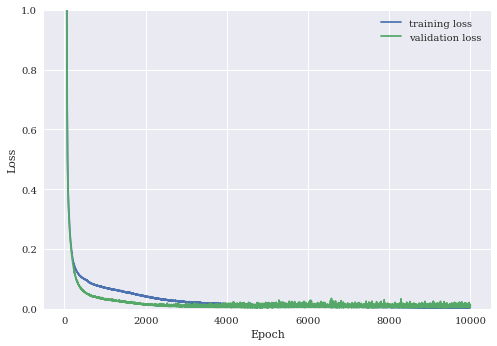

500/500 [==============================] - 0s 60us/sample - loss: 0.0023 - R2: 0.9885
Test Loss: 0.002348
Test R2: 0.9885


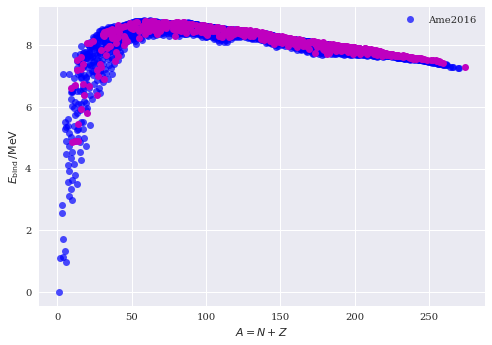

In [24]:
import os

import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
import h5py
import pandas as pd
import sklearn.linear_model as skl
from pylab import plt, mpl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report

plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'

def MakePlot(x,y, styles, labels, axlabels):
    plt.figure(figsize=(10,6))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label = labels[i])
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0)
    
# R2 metric for tensorflow from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("MassEval2016.dat"),'r')

# Prevent TensorFlow from showing us deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)

# Read the experimental data with Pandas
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000

# Group the DataFrame by nucleon number, A.
#Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
#Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])
A = Masses['A']
Z = Masses['Z']
N = Masses['N']
Element = Masses['Element']
Energies = Masses['Ebinding']

## All above comes from another notebook

# Build input array
xx = (Z.as_matrix()[:],N.as_matrix()[:])
xx = np.asarray(xx)
xx=xx.T
yy = Energies

# Get a test set for later
x_train, x_test, y_train, y_test = train_test_split(xx,yy,test_size=0.2,random_state=42)

# Scale input

xs_train = x_train.astype(np.float64)
xs_test = x_test.astype(np.float64)

xs_train[:,0] = (x_train[:,0] - np.average(xx[:,0])) / np.average(xx[:,0])
xs_test[:,0] = (x_test[:,0] - np.average(xx[:,0])) / np.average(xx[:,0])
xs_train[:,1] = (x_train[:,1] - np.average(xx[:,1])) / np.average(xx[:,1])
xs_test[:,1] = (x_test[:,1] - np.average(xx[:,1])) / np.average(xx[:,1])

print('Training Features:\n   Shape: {}\n   Type: {}\n'.format(xs_train.shape, xs_train.dtype))
print('Training Targets:\n   Shape: {}\n   Type: {}\n'.format(y_train.shape, y_train.dtype))
print('Test Features:\n   Shape: {}\n   Type: {}\n'.format(xs_test.shape, xs_test.dtype))
print('Test Targets:\n   Shape: {}\n   Type: {}\n'.format(y_test.shape, y_test.dtype))

nodes = 50
activation="relu"
model=tf.keras.Sequential() #Define the model object
model.add(tf.keras.layers.Dense(nodes,input_shape=(2,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(nodes,input_shape=(nodes,),activation=activation)) #Add the hidden layer
model.add(tf.keras.layers.Dense(1)) #Add the output layer
model.compile(tf.keras.optimizers.Adam(lr=0.0001),loss='mean_squared_error',metrics=[R2]) #Adam optimizer and mean squared error loss
results=model.fit(xs_train,y_train,epochs=1000, batch_size=8, validation_split=0.2,verbose=1)

history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

# test loss calculation

[test_loss,test_R2]=model.evaluate(xs_test, y_test, verbose=1)

print('Test Loss: {:.04}'.format(test_loss))
print('Test R2: {:.04}'.format(test_R2))

en_out=model.predict(xs_test)

# Shift back for plotting

x_shift=xs_test
x_shift[:,0]=xs_test[:,0]*np.average(x_test[:,0])+np.average(x_test[:,0])
x_shift[:,1]=xs_test[:,1]*np.average(x_test[:,1])+np.average(x_test[:,1])

a_sum=np.sum(x_shift,axis=1)

fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], 'ro',
            label='Ame2016', alpha=0.7,c='b')
ax.plot(a_sum, en_out,'ro',c='m')
ax.legend()
save_fig("Masses2016")
plt.show()

### Run a little more

If you want to run further epochs with the output model as a starting point, this cell should do it for you

Train on 1597 samples, validate on 400 samples
Epoch 1/20
1597/1597 [==============================] - 0s 245us/sample - loss: 0.0065 - R2: 0.9854 - val_loss: 0.0286 - val_R2: 0.9763
Epoch 2/20
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0461 - R2: 0.9249 - val_loss: 0.0664 - val_R2: 0.9592
Epoch 3/20
1597/1597 [==============================] - 0s 225us/sample - loss: 0.0179 - R2: 0.9739 - val_loss: 0.0155 - val_R2: 0.9895
Epoch 4/20
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0092 - R2: 0.9852 - val_loss: 0.0325 - val_R2: 0.9803
Epoch 5/20
1597/1597 [==============================] - 0s 226us/sample - loss: 0.0049 - R2: 0.9886 - val_loss: 0.0089 - val_R2: 0.9921
Epoch 6/20
1597/1597 [==============================] - 0s 230us/sample - loss: 0.0036 - R2: 0.9884 - val_loss: 0.0144 - val_R2: 0.9891
Epoch 7/20
1597/1597 [==============================] - 0s 231us/sample - loss: 0.0031 - R2: 0.9925 - val_loss: 0.0211 - val_R2: 0.9878
E

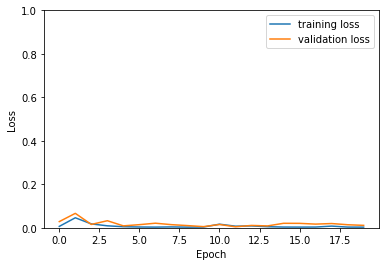

In [9]:
results=model.fit(xs_train,y_train,epochs=20, batch_size=8, validation_split=0.2,verbose=1)

en_out=model.predict(xs_test)

# Shift back for plotting

x_shift=xs_test
x_shift[:,0]=xs_test[:,0]*np.average(x_test[:,0])+np.average(x_test[:,0])
x_shift[:,1]=xs_test[:,1]*np.average(x_test[:,1])+np.average(x_test[:,1])

a_sum=np.sum(x_shift,axis=1)

fig, ax = plt.subplots()
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}\,/\mathrm{MeV}$')
ax.plot(Masses['A'], Masses['Ebinding'], 'ro',
            label='Ame2016', alpha=0.7,c='b')
ax.plot(a_sum, en_out,'ro',c='m')
ax.legend()
save_fig("Masses2016")
plt.show()

history = results.history
plt.plot(history["loss"], label="training loss")
plt.plot(history["val_loss"], label="validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.ylim(0,1)
plt.show()

### Make some predictions

We can, in principle, hand the neural net a N,Z array, and predict binding energies

In [16]:
N=8
Z=8

Zs=(Z - np.average(xx[:,0])) / np.average(xx[:,0])
Ns=(N - np.average(xx[:,1])) / np.average(xx[:,1])

nucleus=np.array([[Zs,Ns]])

[[BE]] = model.predict(nucleus)

print("Binding Energy Per Nucleon: ",BE)
print("Binding Energy: ",BE*(N+Z))

Binding Energy Per Nucleon:  7.689691
Binding Energy:  123.0350570678711


## Save the model for posterity

Since it takes a long time to train

In [25]:
# This won't overwrite the 'real' trained github file
model.save('neuralmasses_testing.h5')
